# 0. Dataset Analysis

In [1]:
from __future__ import annotations

import random
from pathlib import Path

import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

# Point this at the folder created by prepare_nutrition5k.py
PREPARED_DIR = Path('prepared')
TRAIN_DIR = PREPARED_DIR / 'train'
TEST_DIR = PREPARED_DIR / 'test'

TRAIN_INDEX = TRAIN_DIR / 'index.csv'
TEST_INDEX = TEST_DIR / 'index.csv'

assert TRAIN_INDEX.exists(), f'Missing: {TRAIN_INDEX.resolve()}'
assert TEST_INDEX.exists(), f'Missing: {TEST_INDEX.resolve()}'

pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 140)

print('Prepared dir:', PREPARED_DIR.resolve())

Prepared dir: D:\Alternative Assessment XAI\prepared


In [2]:
train_df = pd.read_csv(TRAIN_INDEX)
test_df = pd.read_csv(TEST_INDEX)

df = pd.concat([train_df, test_df], ignore_index=True)

print('Train rows:', len(train_df))
print('Test rows: ', len(test_df))
print('All rows:  ', len(df))

print('Unique train dishes:', train_df['dish_id'].nunique())
print('Unique test dishes: ', test_df['dish_id'].nunique())

display(df.head(10))

# High-level breakdown
display(df.groupby(['split', 'source']).size().rename('count').reset_index())

if 'camera' in df.columns:
    cam_counts = (
        df[df['source'] == 'side_frame']
        .groupby(['split', 'camera'])
        .size()
        .rename('count')
        .reset_index()
        .sort_values(['split', 'camera'])
    )
    display(cam_counts)

# Images per dish distribution
img_per_dish = df.groupby(['split', 'dish_id']).size().rename('num_images').reset_index()
display(img_per_dish.groupby('split')['num_images'].describe())

Train rows: 82787
Test rows:  14169
All rows:   96956
Unique train dishes: 4047
Unique test dishes:  709


dish_id  split                                         image_path      source camera  calories  mass    fat  carb  protein
0  dish_1550862840  train  dish_1550862840/images/frames_camera_A/camera_...  side_frame      A      16.5  33.0  0.033  4.29    0.165
1  dish_1550862840  train  dish_1550862840/images/frames_camera_A/camera_...  side_frame      A      16.5  33.0  0.033  4.29    0.165
2  dish_1550862840  train  dish_1550862840/images/frames_camera_A/camera_...  side_frame      A      16.5  33.0  0.033  4.29    0.165
3  dish_1550862840  train  dish_1550862840/images/frames_camera_A/camera_...  side_frame      A      16.5  33.0  0.033  4.29    0.165
4  dish_1550862840  train  dish_1550862840/images/frames_camera_A/camera_...  side_frame      A      16.5  33.0  0.033  4.29    0.165
5  dish_1550862840  train  dish_1550862840/images/frames_camera_A/camera_...  side_frame      A      16.5  33.0  0.033  4.29    0.165
6  dish_1550862840  train  dish_1550862840/images/frames_camera_A/camera_...  side_frame      A      16.5  33.0  0.033  4.29    0.165
7  dish_1550862840  train  dish_1550862840/images/frames_camera_A/camera_...  side_frame      A      16.5  33.0  0.033  4.29    0.165
8  dish_1550862840  train  dish_1550862840/images/frames_camera_B/camera_...  side_frame      B      16.5  33.0  0.033  4.29    0.165
9  dish_1550862840  train  dish_1550862840/images/frames_camera_B/camera_...  side_frame      B      16.5  33.0  0.033  4.29    0.165

split      source  count
0   test    overhead    507
1   test  side_frame  13662
2  train    overhead   2755
3  train  side_frame  80032

split camera  count
0   test      A   3266
1   test      B   3450
2   test      C   3454
3   test      D   3492
4  train      A  19136
5  train      B  20309
6  train      C  20194
7  train      D  20393

count       mean       std  min   25%   50%   75%   max
split                                                          
test    709.0  19.984485  8.418002  1.0  17.0  17.0  32.0  33.0
train  4047.0  20.456387  8.166884  1.0  17.0  17.0  32.0  33.0

### Random visual samples
This cell picks a few random dish IDs and displays the overhead image (if present) plus a handful of side frames.

train/dish_1565640427 | calories=195.8 | mass=42.0g | fat=12.10g | carb=20.92g | protein=2.60g


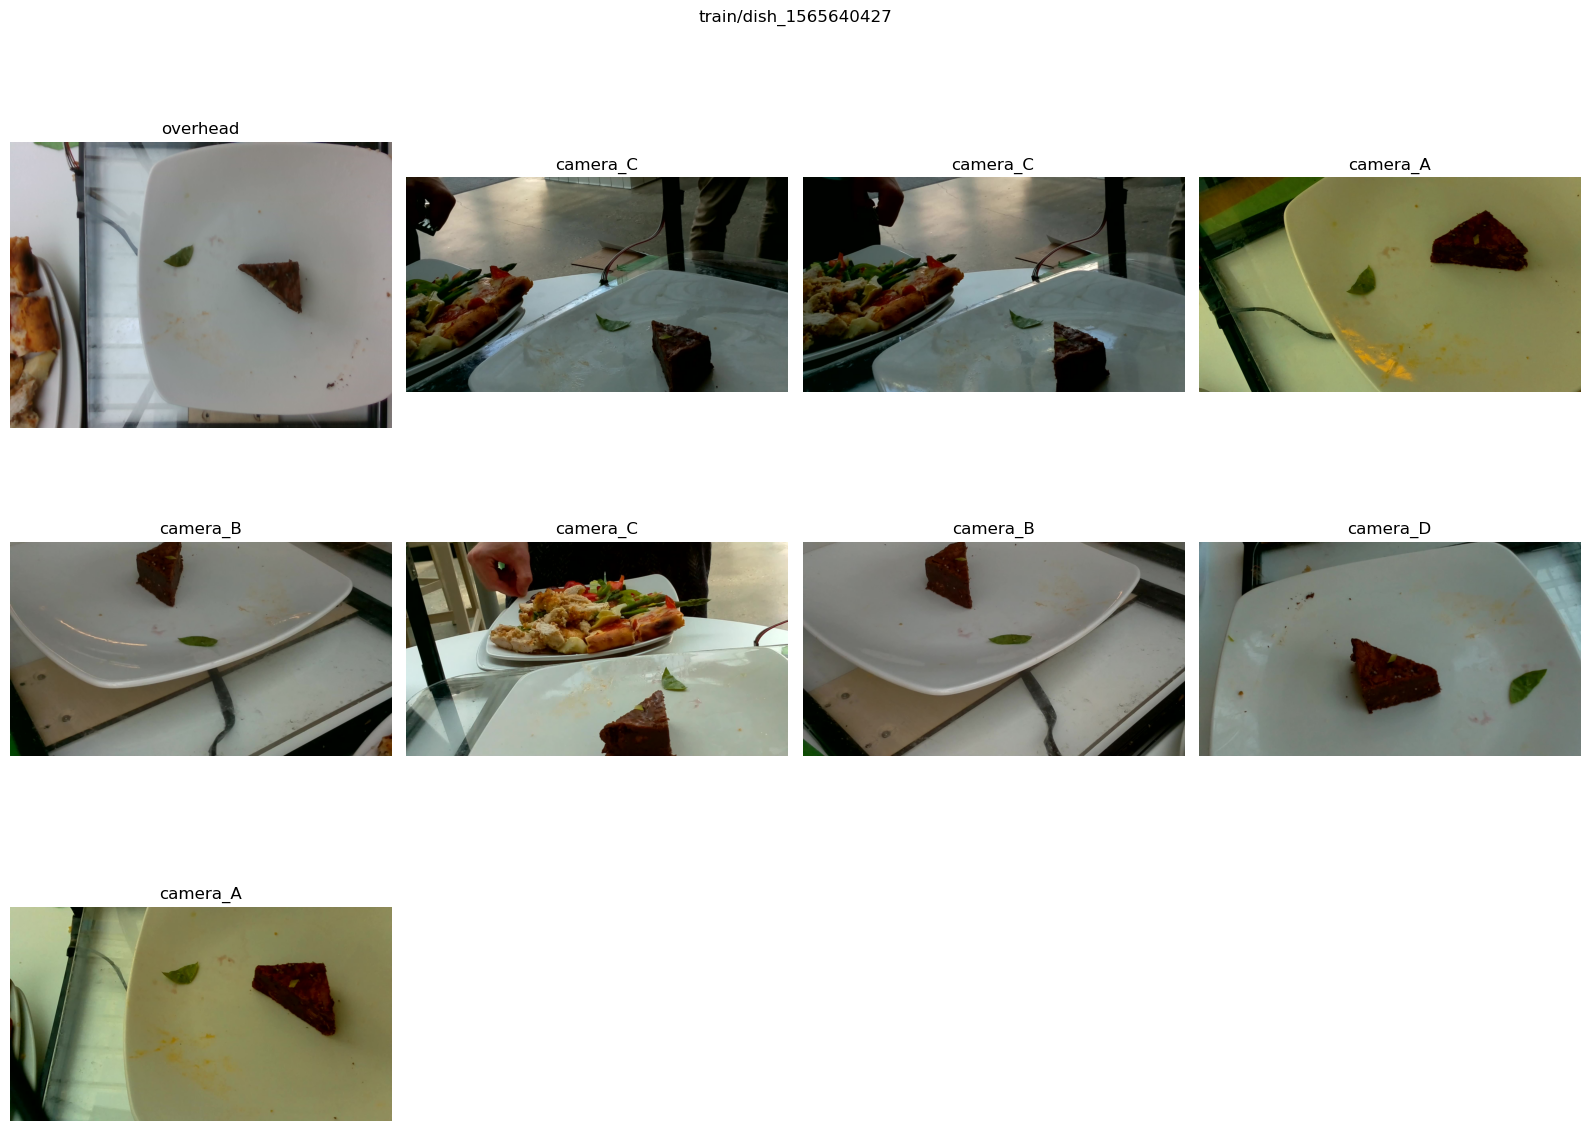

test/dish_1563294987 | calories=97.4 | mass=18.0g | fat=7.56g | carb=0.25g | protein=6.66g


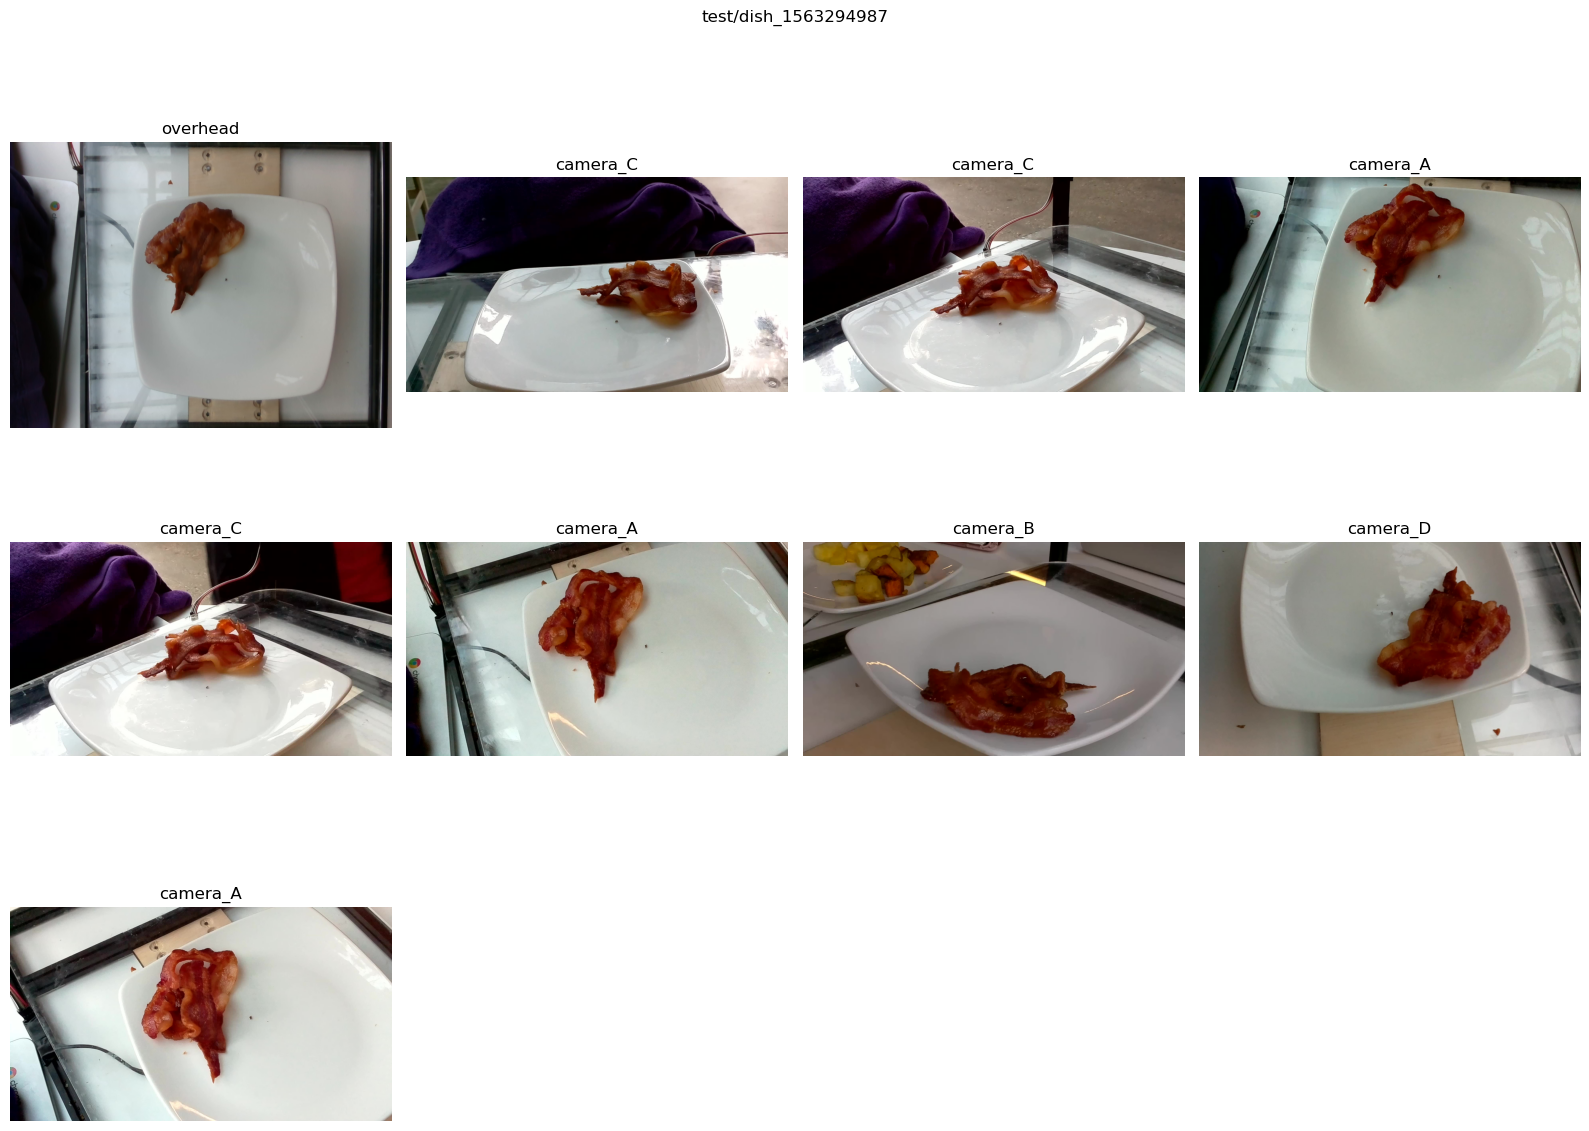

In [3]:
def load_image(path: Path) -> Image.Image | None:
    try:
        return Image.open(path).convert('RGB')
    except Exception:
        return None

def _dish_metadata_row(dish_id: str, split: str) -> dict | None:
    base_df = train_df if split == 'train' else test_df
    rows = base_df[base_df['dish_id'] == dish_id]
    if len(rows) == 0:
        return None
    r = rows.iloc[0]
    return {
        'dish_id': dish_id,
        'split': split,
        'calories': float(r['calories']),
        'mass': float(r['mass']),
        'fat': float(r['fat']),
        'carb': float(r['carb']),
        'protein': float(r['protein']),
    }

def show_dish_samples(dish_id: str, split: str, max_side_frames: int = 8):
    split_dir = TRAIN_DIR if split == 'train' else TEST_DIR
    dish_dir = split_dir / dish_id / 'images'

    meta = _dish_metadata_row(dish_id, split)
    if meta is not None:
        print(
            f"{split}/{dish_id} | calories={meta['calories']:.1f} | mass={meta['mass']:.1f}g | "
            f"fat={meta['fat']:.2f}g | carb={meta['carb']:.2f}g | protein={meta['protein']:.2f}g"
        )
    else:
        print(f"{split}/{dish_id} | metadata not found in index.csv")

    overhead = dish_dir / 'overhead_rgb.png'
    side_frames = []
    for cam_dir in sorted(dish_dir.glob('frames_camera_*')):
        frames = sorted(cam_dir.glob('*.jpeg'))
        side_frames.extend(frames)

    # Sample a subset for display
    if len(side_frames) > max_side_frames:
        side_frames = random.sample(side_frames, k=max_side_frames)

    imgs = []
    titles = []

    if overhead.exists():
        img = load_image(overhead)
        if img is not None:
            imgs.append(img)
            titles.append('overhead')

    for p in side_frames:
        img = load_image(p)
        if img is None:
            continue
        imgs.append(img)
        titles.append(p.parent.name.replace('frames_', ''))

    if not imgs:
        print(f'No images found for {split}/{dish_id}')
        return

    n = len(imgs)
    cols = min(4, n)
    rows = (n + cols - 1) // cols

    plt.figure(figsize=(4 * cols, 4 * rows))
    for i, (img, title) in enumerate(zip(imgs, titles), start=1):
        ax = plt.subplot(rows, cols, i)
        ax.imshow(img)
        ax.set_title(title)
        ax.axis('off')
    plt.suptitle(f'{split}/{dish_id}', y=1.02)
    plt.tight_layout()
    plt.show()

# Pick some random dishes that have at least 1 image
random.seed(0)
train_dishes = sorted(train_df['dish_id'].unique())
test_dishes = sorted(test_df['dish_id'].unique())

for dish_id in random.sample(train_dishes, k=min(1, len(train_dishes))):
    show_dish_samples(dish_id, split='train', max_side_frames=8)

for dish_id in random.sample(test_dishes, k=min(1, len(test_dishes))):
    show_dish_samples(dish_id, split='test', max_side_frames=8)

# 1. Data Preprocessing

In [4]:
import math
from dataclasses import dataclass
from typing import Optional

try:
    import torch
    from torch.utils.data import Dataset, DataLoader
    from torchvision import transforms
except Exception as e:
    raise ImportError(
        "PyTorch/torchvision not available in this kernel. "
        "Install torch + torchvision, then restart the kernel.\n"
        f"Original error: {e}"
    )

print('torch:', torch.__version__)

torch: 2.5.1+cu124


In [5]:
# Define normalization + augmentation
IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD = (0.229, 0.224, 0.225)

# Choose your training resolution
IMAGE_SIZE = 320

train_transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE + 32),
    transforms.CenterCrop(IMAGE_SIZE),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])

test_transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE + 32),
    transforms.CenterCrop(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])

train_transform, test_transform

(Compose(
     Resize(size=352, interpolation=bilinear, max_size=None, antialias=True)
     CenterCrop(size=(320, 320))
     RandomHorizontalFlip(p=0.5)
     RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
     ToTensor()
     Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
 ),
 Compose(
     Resize(size=352, interpolation=bilinear, max_size=None, antialias=True)
     CenterCrop(size=(320, 320))
     ToTensor()
     Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
 ))

In [6]:
# Multi-task target columns (we can train on all 5, but still report calories later)
TARGET_COLS = ['calories', 'mass', 'fat', 'carb', 'protein']

@dataclass(frozen=True)
class Sample:
    image_path: Path
    y: list[float]
    dish_id: str
    source: str
    camera: str

class Nutrition5kImageDataset(Dataset):
    def __init__(
        self,
        index_df: pd.DataFrame,
        split_dir: Path,
        transform=None,
        target_cols: list[str] = TARGET_COLS,
        log_calories: bool = False,
        validate_paths: bool = False,
    ):
        self.split_dir = split_dir
        self.transform = transform
        self.target_cols = target_cols
        self.log_calories = log_calories

        required_cols = {'dish_id', 'image_path', 'source', 'camera'} | set(target_cols)
        missing_cols = required_cols - set(index_df.columns)
        if missing_cols:
            raise ValueError(f'index.csv missing columns: {sorted(missing_cols)}')

        paths = index_df['image_path'].astype(str).tolist()
        dish_ids = index_df['dish_id'].astype(str).tolist()
        sources = index_df.get('source', '').astype(str).tolist() if 'source' in index_df.columns else [''] * len(index_df)
        cameras = index_df.get('camera', '').astype(str).fillna('').tolist() if 'camera' in index_df.columns else [''] * len(index_df)
        ys = index_df[target_cols].astype(float).values.tolist()

        rows: list[Sample] = []
        for p_rel, dish_id, src, cam, y in zip(paths, dish_ids, sources, cameras, ys):
            p = split_dir / p_rel
            if validate_paths and not p.exists():
                continue
            rows.append(Sample(
                image_path=p,
                y=[float(v) for v in y],
                dish_id=dish_id,
                source=src,
                camera=cam,
            ))
        if len(rows) == 0:
            raise RuntimeError(
                f'No samples found. If your index has paths, try validate_paths=False (default) or check prepared folder: {split_dir.resolve()}'
            )
        self.rows = rows

    def __len__(self):
        return len(self.rows)

    def __getitem__(self, idx):
        s = self.rows[idx]
        img = Image.open(s.image_path).convert('RGB')
        if self.transform is not None:
            img = self.transform(img)

        y = torch.tensor(s.y, dtype=torch.float32)  # shape: (5,) by default
        if self.log_calories:
            # Only log-transform the first target (calories) if calories is first in target_cols.
            # This keeps the other nutrition targets in their natural units.
            if len(self.target_cols) > 0 and self.target_cols[0] == 'calories':
                y0 = torch.log1p(torch.clamp(y[0], min=0.0))
                y = torch.cat([y0.view(1), y[1:]], dim=0)

        meta = {
            'dish_id': s.dish_id,
            'source': s.source,
            'camera': s.camera,
            'path': str(s.image_path),
            'target_cols': self.target_cols,
        }
        return img, y, meta


class Nutrition5kDishDataset(Dataset):
    """Dish-level dataset for multi-instance learning.

    Each item is a dish: we sample K images for the dish, run the model per-image,
    then mean-pool predictions before computing loss against the dish target.
    """

    def __init__(
        self,
        index_df: pd.DataFrame,
        split_dir: Path,
        transform=None,
        target_cols: list[str] = TARGET_COLS,
        images_per_dish: int = 8,
        sample_mode: str = 'random',
        validate_paths: bool = False,
    ):
        self.split_dir = split_dir
        self.transform = transform
        self.target_cols = target_cols
        self.images_per_dish = int(images_per_dish)
        self.sample_mode = str(sample_mode)

        required_cols = {'dish_id', 'image_path', 'source', 'camera'} | set(target_cols)
        missing_cols = required_cols - set(index_df.columns)
        if missing_cols:
            raise ValueError(f'index.csv missing columns: {sorted(missing_cols)}')

        # Group rows by dish
        grouped: dict[str, list[Sample]] = {}
        for _, r in index_df.iterrows():
            dish_id = str(r['dish_id'])
            p_rel = str(r['image_path'])
            p = split_dir / p_rel
            if validate_paths and not p.exists():
                continue
            y = [float(r[c]) for c in target_cols]
            grouped.setdefault(dish_id, []).append(Sample(
                image_path=p,
                y=y,
                dish_id=dish_id,
                source=str(r.get('source', '')),
                camera=str(r.get('camera', '')) if 'camera' in r else '',
            ))

        self.dish_ids = sorted(grouped.keys())
        self.by_dish = grouped
        if len(self.dish_ids) == 0:
            raise RuntimeError(f'No dishes found for {split_dir.resolve()}')

    def __len__(self):
        return len(self.dish_ids)

    def __getitem__(self, idx):
        dish_id = self.dish_ids[idx]
        rows = self.by_dish[dish_id]

        # Dish target (all rows share the same y)
        y = torch.tensor(rows[0].y, dtype=torch.float32)

        # Choose which images to use
        n = len(rows)
        k = min(self.images_per_dish, n) if self.images_per_dish > 0 else n

        if self.sample_mode == 'all' or self.images_per_dish <= 0:
            chosen = rows
        else:
            # Random sample each __getitem__ call; if n < K, sample with replacement
            if n >= self.images_per_dish:
                chosen = random.sample(rows, k=self.images_per_dish)
            else:
                chosen = [random.choice(rows) for _ in range(self.images_per_dish)]

        imgs = []
        metas = []
        for s in chosen:
            img = Image.open(s.image_path).convert('RGB')
            if self.transform is not None:
                img = self.transform(img)
            imgs.append(img)
            metas.append({'path': str(s.image_path), 'source': s.source, 'camera': s.camera})

        # Stack to (K, 3, H, W)
        x = torch.stack(imgs, dim=0)
        meta = {'dish_id': dish_id, 'k': x.shape[0], 'imgs': metas, 'target_cols': self.target_cols}
        return x, y, meta

In [25]:
# Create train/test datasets + loaders
# We keep:
# - Per-image datasets (train_dataset/test_dataset) for visualization / XAI
# - Dish-level datasets (train_dish_dataset/test_dish_dataset) for training with dish pooling

TARGET_COLS = ['calories', 'mass', 'fat', 'carb', 'protein']

# Per-image datasets (used later for XAI demos)
train_dataset = Nutrition5kImageDataset(
    index_df=train_df,
    split_dir=TRAIN_DIR,
    transform=train_transform,
    target_cols=TARGET_COLS,
    log_calories=False,
    validate_paths=False,
)
test_dataset = Nutrition5kImageDataset(
    index_df=test_df,
    split_dir=TEST_DIR,
    transform=test_transform,
    target_cols=TARGET_COLS,
    log_calories=False,
    validate_paths=False,
)

# Dish-level datasets (used for training/eval)
IMAGES_PER_DISH_TRAIN = 8
IMAGES_PER_DISH_EVAL = 16

train_dish_dataset = Nutrition5kDishDataset(
    index_df=train_df,
    split_dir=TRAIN_DIR,
    transform=train_transform,
    target_cols=TARGET_COLS,
    images_per_dish=IMAGES_PER_DISH_TRAIN,
    sample_mode='random',
    validate_paths=False,
)

test_dish_dataset = Nutrition5kDishDataset(
    index_df=test_df,
    split_dir=TEST_DIR,
    transform=test_transform,
    target_cols=TARGET_COLS,
    images_per_dish=IMAGES_PER_DISH_EVAL,
    sample_mode='random',  # random subset; set 'all' and images_per_dish<=0 to use all images per dish
    validate_paths=False,
)

BATCH_SIZE = 32  # per-image loaders (XAI / optional)
DISH_BATCH_SIZE = 8  # dish batches are heavier: each item contains K images

NUM_WORKERS = 0

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=torch.cuda.is_available(),
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=torch.cuda.is_available(),
)

train_dish_loader = DataLoader(
    train_dish_dataset,
    batch_size=DISH_BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=torch.cuda.is_available(),
)

test_dish_loader = DataLoader(
    test_dish_dataset,
    batch_size=DISH_BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=torch.cuda.is_available(),
)

print('Per-image train samples:', len(train_dataset))
print('Per-image test samples :', len(test_dataset))
print('Dish-level train dishes:', len(train_dish_dataset))
print('Dish-level test dishes :', len(test_dish_dataset))

# Quick sanity check: dish sample shapes
x_d, y_d, m_d = train_dish_dataset[0]
print('One dish sample x:', tuple(x_d.shape), '(K,3,H,W)')
print('Dish y shape:', tuple(y_d.shape))
print('Dish meta keys:', list(m_d.keys()))
print('Dish id:', m_d.get('dish_id'), '| K:', m_d.get('k') )

Per-image train samples: 82787
Per-image test samples : 14169
Dish-level train dishes: 4047
Dish-level test dishes : 709
One dish sample x: (8, 3, 320, 320) (K,3,H,W)
Dish y shape: (5,)
Dish meta keys: ['dish_id', 'k', 'imgs', 'target_cols']
Dish id: dish_1550704750 | K: 8


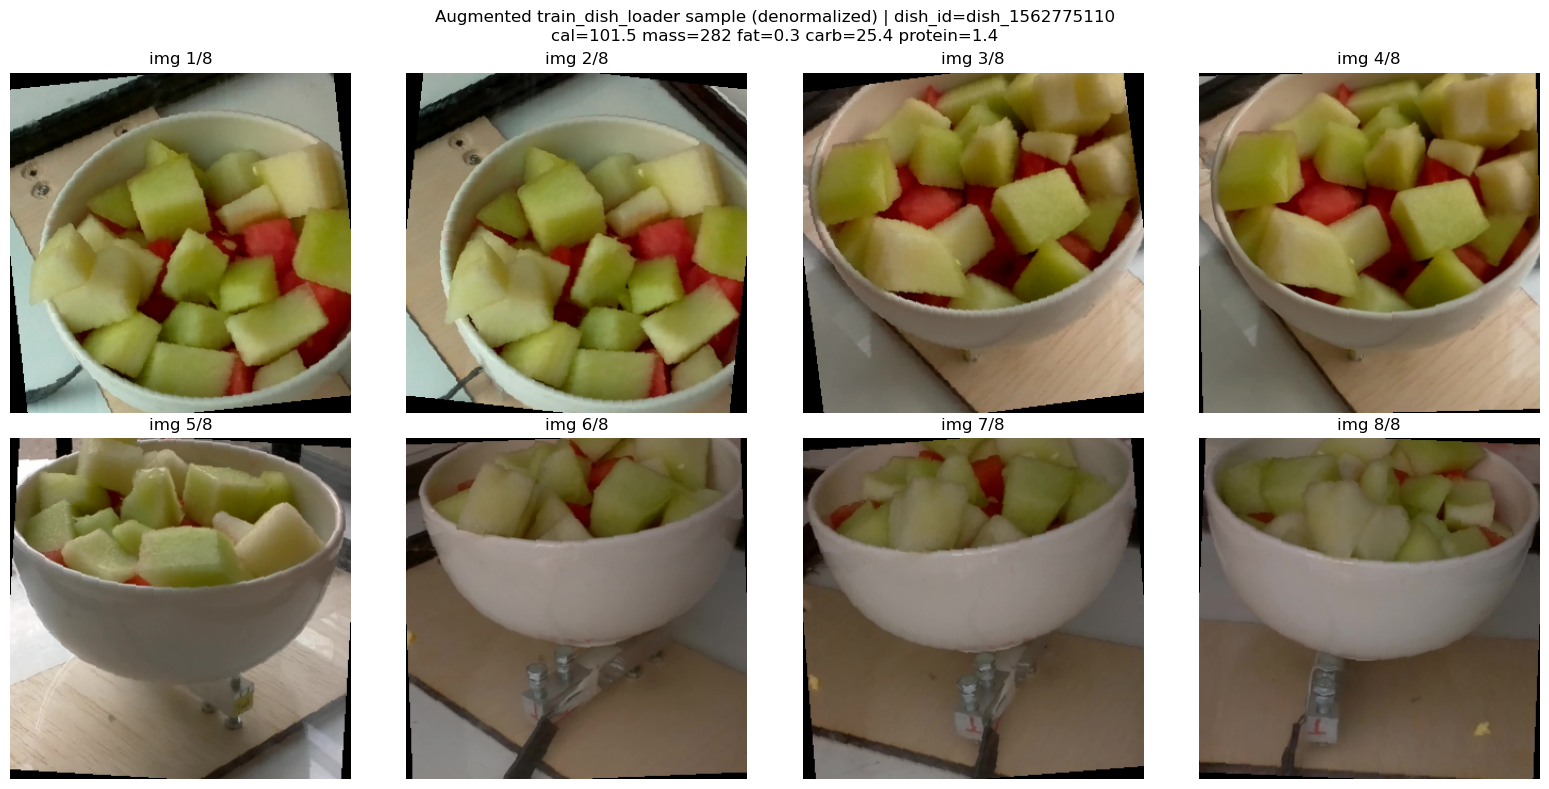

In [8]:
# Visualize one augmented DISH training batch (denormalized) from train_dish_loader
def denormalize(t: torch.Tensor, mean=IMAGENET_MEAN, std=IMAGENET_STD):
    mean_t = torch.tensor(mean, dtype=t.dtype, device=t.device).view(3, 1, 1)
    std_t = torch.tensor(std, dtype=t.dtype, device=t.device).view(3, 1, 1)
    return t * std_t + mean_t

x_dish, y_dish, meta_dish = next(iter(train_dish_loader))
# x_dish: (B, K, 3, H, W)  y_dish: (B, 5)
x0 = x_dish[0]  # (K, 3, H, W) for the first dish in the batch
y0 = y_dish[0]  # (5,)

dish_id0 = None
try:
    if isinstance(meta_dish, dict) and 'dish_id' in meta_dish and len(meta_dish['dish_id']) > 0:
        dish_id0 = meta_dish['dish_id'][0]
except Exception:
    dish_id0 = None

imgs_vis = denormalize(x0).clamp(0, 1).detach().cpu()
K = imgs_vis.shape[0]
show_k = min(K, 8)

cols = 4
rows = int(math.ceil(show_k / cols))
plt.figure(figsize=(16, 4 * rows))
for i in range(show_k):
    ax = plt.subplot(rows, cols, i + 1)
    ax.imshow(imgs_vis[i].permute(1, 2, 0))
    ax.set_title(f"img {i+1}/{K}")
    ax.axis('off')

cal = float(y0[0])
mass = float(y0[1])
fat = float(y0[2])
carb = float(y0[3])
protein = float(y0[4])
title = f"Augmented train_dish_loader sample (denormalized)"
if dish_id0 is not None:
    title += f" | dish_id={dish_id0}"
title += f"\ncal={cal:.1f} mass={mass:.0f} fat={fat:.1f} carb={carb:.1f} protein={protein:.1f}"
plt.suptitle(title)
plt.tight_layout()
plt.show()

# 2. Model Training

In [9]:
# Training utilities + target standardization
import time
from collections import defaultdict

import numpy as np

try:
    from tqdm.auto import tqdm
except Exception:
    def tqdm(x, *args, **kwargs):
        return x

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', DEVICE)

# Standardization stats computed on TRAIN (per target column)
TARGET_COLS = ['calories', 'mass', 'fat', 'carb', 'protein']
target_mean = torch.tensor(train_df[TARGET_COLS].mean().values, dtype=torch.float32)
target_std = torch.tensor(train_df[TARGET_COLS].std(ddof=0).values, dtype=torch.float32)

# Avoid divide-by-zero in case any column is constant
target_std = torch.clamp(target_std, min=1e-6)

print('Target mean:', dict(zip(TARGET_COLS, [float(v) for v in target_mean])))
print('Target std :', dict(zip(TARGET_COLS, [float(v) for v in target_std])))

Device: cuda
Target mean: {'calories': 200.8631134033203, 'mass': 177.81732177734375, 'fat': 9.92558765411377, 'carb': 16.65521240234375, 'protein': 13.689811706542969}
Target std : {'calories': 276.1405334472656, 'mass': 307.6825256347656, 'fat': 20.731624603271484, 'carb': 31.870038986206055, 'protein': 17.844282150268555}


In [10]:
# Build ConvNeXt-Tiny pretrained model (torchvision)
from torchvision.models import convnext_tiny, ConvNeXt_Tiny_Weights

weights = ConvNeXt_Tiny_Weights.DEFAULT
model = convnext_tiny(weights=weights)

# Replace classification head: -> (N, 5)
# ConvNeXt uses `classifier` as the final sequential layer
in_features = model.classifier[-1].in_features
model.classifier[-1] = torch.nn.Linear(in_features, len(TARGET_COLS))

model = model.to(DEVICE)

# AMP
scaler = torch.amp.GradScaler('cuda', enabled=(DEVICE.type == 'cuda'))

# Loss on standardized targets (PyTorch Huber)
criterion = torch.nn.HuberLoss(delta=1.0, reduction='mean')

# Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

def _count_params(m: torch.nn.Module):
    total = sum(p.numel() for p in m.parameters())
    trainable = sum(p.numel() for p in m.parameters() if p.requires_grad)
    return total, trainable

total_p, trainable_p = _count_params(model)
print('Model:', model.__class__.__name__)
print('Backbone:', 'convnext_tiny', '| head out:', len(TARGET_COLS))
print(f'Params: {total_p/1e6:.2f}M (trainable: {trainable_p/1e6:.2f}M)')
print('Input size (recommended):', weights.transforms().crop_size)
print('--- Model ---')
print(model)

Model: ConvNeXt
Backbone: convnext_tiny | head out: 5
Params: 27.82M (trainable: 27.82M)
Input size (recommended): [224]
--- Model ---
ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, out_features=384, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=384, out_features=96, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), gro

In [12]:
import time

try:
    from tqdm.auto import tqdm
except Exception:
    def tqdm(x, *args, **kwargs):
        return x

def _to_device(x, device: torch.device):
    return x.to(device, non_blocking=True) if isinstance(x, torch.Tensor) else x

def _is_finite(x: torch.Tensor) -> bool:
    return bool(torch.isfinite(x).all().item())

def _dish_forward_z(model: torch.nn.Module, xb: torch.Tensor) -> torch.Tensor:
    """
    xb: (B, K, 3, H, W)
    returns pred_z: (B, 5) by mean pooling predictions across K.
    """
    b, k, c, h, w = xb.shape
    xb_flat = xb.view(b * k, c, h, w)
    with torch.amp.autocast(device_type=DEVICE.type, enabled=(DEVICE.type == "cuda")):
        pred_z_flat = model(xb_flat)  # (B*K, 5)
    return pred_z_flat.view(b, k, -1).mean(dim=1)  # (B, 5)

def train_one_epoch_dish_pool(
    model,
    dish_loader,
    optimizer,
    scaler,
    criterion,
    target_mean,
    target_std,
    desc: str = "Train(dish)",
    max_grad_norm: float = 1.0,
    skip_non_finite: bool = True,
) -> float:
    """Train one epoch using z-scored targets and Huber loss over ALL 5 outputs."""
    model.train()
    target_mean = target_mean.to(DEVICE)
    target_std = target_std.to(DEVICE)

    loss_sum = 0.0
    n = 0

    for xb, yb, _ in tqdm(dish_loader, desc=desc, leave=False):
        xb = _to_device(xb, DEVICE)
        yb = _to_device(yb, DEVICE)

        if skip_non_finite and not _is_finite(yb):
            continue

        y_z = (yb - target_mean) / target_std
        if skip_non_finite and not _is_finite(y_z):
            continue

        optimizer.zero_grad(set_to_none=True)

        pred_z = _dish_forward_z(model, xb)
        loss = criterion(pred_z.float(), y_z)

        if skip_non_finite and ((not _is_finite(pred_z)) or (not torch.isfinite(loss))):
            optimizer.zero_grad(set_to_none=True)
            continue

        scaler.scale(loss).backward()

        if max_grad_norm is not None and max_grad_norm > 0:
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=float(max_grad_norm))

        scaler.step(optimizer)
        scaler.update()

        b = yb.size(0)
        loss_sum += float(loss.item()) * b
        n += b

    return loss_sum / max(n, 1)

@torch.no_grad()
def evaluate_dish_pool(
    model,
    dish_loader,
    criterion,
    target_mean,
    target_std,
    desc: str = "Val(dish)",
    skip_non_finite: bool = True,
):
    """
    Returns:
      - val_loss_z: Huber loss on z-scored targets over ALL 5 outputs
      - val_mae: mean absolute error in raw units over ALL 5 outputs (averaged across targets)
      - val_mae_per_target: dict of raw-unit MAE per target
    """
    model.eval()
    target_mean = target_mean.to(DEVICE)
    target_std = target_std.to(DEVICE)

    loss_sum = 0.0
    n_loss = 0

    abs_sum_per_target = torch.zeros(len(TARGET_COLS), dtype=torch.float64)
    n_mae = 0

    for xb, yb, _ in tqdm(dish_loader, desc=desc, leave=False):
        xb = _to_device(xb, DEVICE)
        yb = _to_device(yb, DEVICE)

        if skip_non_finite and not _is_finite(yb):
            continue

        y_z = (yb - target_mean) / target_std
        if skip_non_finite and not _is_finite(y_z):
            continue

        pred_z = _dish_forward_z(model, xb)
        loss = criterion(pred_z.float(), y_z)

        if skip_non_finite and ((not _is_finite(pred_z)) or (not torch.isfinite(loss))):
            continue

        b = yb.size(0)
        loss_sum += float(loss.item()) * b
        n_loss += b

        pred = pred_z * target_std + target_mean  # raw units
        abs_sum_per_target += torch.sum(torch.abs(pred - yb), dim=0).detach().cpu().to(torch.float64)
        n_mae += b

    val_loss_z = loss_sum / max(n_loss, 1)
    mae_per_target = (abs_sum_per_target / max(n_mae, 1)).tolist()
    val_mae = float(sum(mae_per_target) / max(len(mae_per_target), 1))

    return {
        "val_loss_z": float(val_loss_z),
        "val_mae": float(val_mae),
        "val_mae_per_target": {k: float(v) for k, v in zip(TARGET_COLS, mae_per_target)},
    }

In [13]:
EPOCHS = 20
PATIENCE = 2
MIN_DELTA = 0.0
MAX_GRAD_NORM = 1.0

val_dish_loader = test_dish_loader  # use provided test split as validation

history = {
    "epoch": [],
    "train_loss_z": [],
    "val_loss_z": [],
    "val_mae": [],
}

best_val = float("inf")
best_epoch = 0
patience_left = PATIENCE
best_state = None

start = time.time()

for epoch in range(1, EPOCHS + 1):
    t0 = time.time()

    train_loss_z = train_one_epoch_dish_pool(
        model,
        train_dish_loader,
        optimizer,
        scaler,
        criterion,
        target_mean,
        target_std,
        desc=f"Train e{epoch:02d}",
        max_grad_norm=MAX_GRAD_NORM,
        skip_non_finite=True,
    )

    val_metrics = evaluate_dish_pool(
        model,
        val_dish_loader,
        criterion,
        target_mean,
        target_std,
        desc=f"Val   e{epoch:02d}",
        skip_non_finite=True,
    )

    val_loss_z = val_metrics["val_loss_z"]
    val_mae = val_metrics["val_mae"]

    history["epoch"].append(epoch)
    history["train_loss_z"].append(float(train_loss_z))
    history["val_loss_z"].append(float(val_loss_z))
    history["val_mae"].append(float(val_mae))

    improved = (best_val - val_loss_z) > MIN_DELTA
    if improved:
        best_val = val_loss_z
        best_epoch = epoch
        patience_left = PATIENCE
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
        status = "best"
    else:
        patience_left -= 1
        status = f"patience={patience_left}/{PATIENCE}"

    dt = time.time() - t0
    print(
        f"Epoch {epoch:02d}/{EPOCHS} | train_loss_z={train_loss_z:.4f} | "
        f"val_loss_z={val_loss_z:.4f} | val_mae(mean)={val_mae:.2f} | "
        f"time={dt/60:.1f}m | {status}"
    )

    if patience_left <= 0:
        print(f"Early stopping at epoch {epoch}. Best val_loss_z={best_val:.4f} @ epoch {best_epoch}.")
        break

if best_state is not None:
    model.load_state_dict(best_state)
    print(f"Restored best model from epoch {best_epoch} (val_loss_z={best_val:.4f}).")

print("Total time (min):", (time.time() - start) / 60.0)

Train e01:   0%|          | 0/506 [00:00<?, ?it/s]

Val   e01:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch 01/20 | train_loss_z=0.0990 | val_loss_z=0.1215 | val_mae(mean)=32.36 | time=103.6m | best


Train e02:   0%|          | 0/506 [00:00<?, ?it/s]

Val   e02:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch 02/20 | train_loss_z=0.0655 | val_loss_z=0.1068 | val_mae(mean)=28.69 | time=86.6m | best


Train e03:   0%|          | 0/506 [00:00<?, ?it/s]

Val   e03:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch 03/20 | train_loss_z=0.0505 | val_loss_z=0.1131 | val_mae(mean)=32.15 | time=81.4m | patience=1/2


Train e04:   0%|          | 0/506 [00:00<?, ?it/s]

Val   e04:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch 04/20 | train_loss_z=0.0442 | val_loss_z=0.1025 | val_mae(mean)=27.44 | time=82.4m | best


Train e05:   0%|          | 0/506 [00:00<?, ?it/s]

Val   e05:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch 05/20 | train_loss_z=0.0383 | val_loss_z=0.1106 | val_mae(mean)=30.28 | time=105.7m | patience=1/2


Train e06:   0%|          | 0/506 [00:00<?, ?it/s]

Val   e06:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch 06/20 | train_loss_z=0.0348 | val_loss_z=0.1004 | val_mae(mean)=27.23 | time=101.4m | best


Train e07:   0%|          | 0/506 [00:00<?, ?it/s]

Val   e07:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch 07/20 | train_loss_z=0.0333 | val_loss_z=0.0965 | val_mae(mean)=27.23 | time=97.9m | best


Train e08:   0%|          | 0/506 [00:00<?, ?it/s]

Val   e08:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch 08/20 | train_loss_z=0.0311 | val_loss_z=0.1070 | val_mae(mean)=28.02 | time=93.3m | patience=1/2


Train e09:   0%|          | 0/506 [00:00<?, ?it/s]

Val   e09:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch 09/20 | train_loss_z=0.0301 | val_loss_z=0.0991 | val_mae(mean)=26.39 | time=99.4m | patience=0/2
Early stopping at epoch 9. Best val_loss_z=0.0965 @ epoch 7.
Restored best model from epoch 7 (val_loss_z=0.0965).
Total time (min): 851.674199171861


In [14]:
from pathlib import Path

CKPT_PATH = Path('convnext_tiny_nutrition5k_bestperdish.pt')

torch.save(
    {
        'model_state_dict': model.state_dict(),
        'backbone': 'convnext_tiny',
        'target_cols': TARGET_COLS,
        'target_mean': target_mean,
        'target_std': target_std,
        'image_size': IMAGE_SIZE,
        'imagenet_mean': IMAGENET_MEAN,
        'imagenet_std': IMAGENET_STD,
        'images_per_dish_train': IMAGES_PER_DISH_TRAIN,
        'images_per_dish_eval': IMAGES_PER_DISH_EVAL,
        'best_epoch': best_epoch,
        'best_val_loss_z': best_val,
    },
    CKPT_PATH,
)

print('Saved:', CKPT_PATH.resolve())
print('best_epoch:', best_epoch, '| best_val_loss_z:', best_val)

Saved: D:\Alternative Assessment XAI\convnext_tiny_nutrition5k_bestperdish.pt
best_epoch: 7 | best_val_loss_z: 0.09646024516348863


# 3. Model Evaluation

In [29]:
# Evaluate the saved ConvNeXt-Tiny dish-pooled model on the test dishes
from pathlib import Path

import torch
from torchvision.models import convnext_tiny, ConvNeXt_Tiny_Weights

CKPT_PATH = Path('convnext_tiny_nutrition5k_bestperdish.pt')
assert CKPT_PATH.exists(), f'Missing checkpoint: {CKPT_PATH.resolve()}'

ckpt = torch.load(CKPT_PATH, map_location='cpu')
print('Loaded:', CKPT_PATH.resolve())
print('Checkpoint keys:', list(ckpt.keys()))

# Rebuild the model and load weights
weights = ConvNeXt_Tiny_Weights.DEFAULT
model_eval = convnext_tiny(weights=weights)

target_cols_ckpt = ckpt.get('target_cols', TARGET_COLS)
model_eval.classifier[-1] = torch.nn.Linear(model_eval.classifier[-1].in_features, len(target_cols_ckpt))

model_eval.load_state_dict(ckpt['model_state_dict'], strict=True)
model_eval = model_eval.to(DEVICE)
model_eval.eval()

# Use saved target stats if present
target_mean_eval = ckpt.get('target_mean', target_mean)
target_std_eval = ckpt.get('target_std', target_std)

print('backbone:', ckpt.get('backbone', 'convnext_tiny'))
print('target_cols:', target_cols_ckpt)
print('best_epoch:', ckpt.get('best_epoch', None), '| best_val_loss_z:', ckpt.get('best_val_loss_z', None))

C:\Users\shany\AppData\Local\Temp\ipykernel_33684\999437393.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(CKPT_PATH, map_location='cpu')


Loaded: D:\Alternative Assessment XAI\convnext_tiny_nutrition5k_bestperdish.pt
Checkpoint keys: ['model_state_dict', 'backbone', 'target_cols', 'target_mean', 'target_std', 'image_size', 'imagenet_mean', 'imagenet_std', 'images_per_dish_train', 'images_per_dish_eval', 'best_epoch', 'best_val_loss_z']
backbone: convnext_tiny
target_cols: ['calories', 'mass', 'fat', 'carb', 'protein']
best_epoch: 7 | best_val_loss_z: 0.09646024516348863


In [30]:
# Compute test metrics on dish loader (recommended for dish-pooled training)
# Note: evaluate_dish_pool() returns loss in z-space + MAE in raw units.

test_metrics_dish = evaluate_dish_pool(
    model_eval,
    test_dish_loader,
    criterion,
    target_mean_eval,
    target_std_eval,
    desc="Test(dish)",
    skip_non_finite=True,
)
print("Test dish metrics:", test_metrics_dish)

Test(dish):   0%|          | 0/89 [00:00<?, ?it/s]

Test dish metrics: {'val_loss_z': 0.09346936231318793, 'val_mae': 26.533275679169993, 'val_mae_per_target': {'calories': 71.60012720535774, 'mass': 44.78048915889939, 'fat': 5.927003733361894, 'carb': 6.103218791515097, 'protein': 4.255539506715847}}


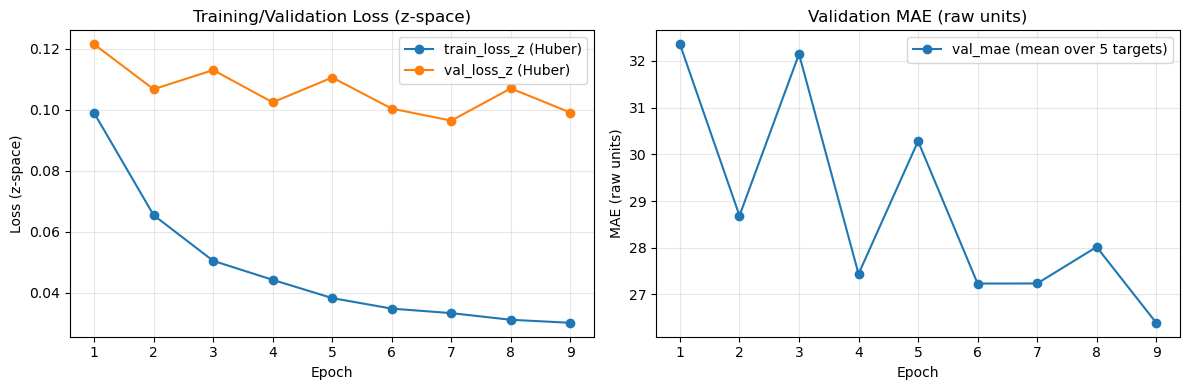

=== Test metrics (recomputed from predictions) ===
Mean MAE (across 5 targets): 26.640737533569336
  calories | MAE=71.770 | RMSE=487.211 | R2=0.139
      mass | MAE=45.136 | RMSE=301.190 | R2=0.145
       fat | MAE=5.977 | RMSE=45.116 | R2=0.087
      carb | MAE=6.079 | RMSE=27.797 | R2=0.194
   protein | MAE=4.241 | RMSE=8.139 | R2=0.819


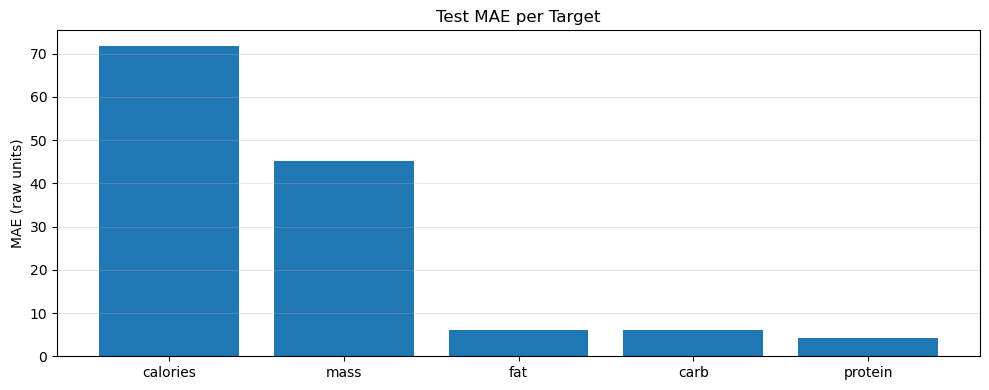

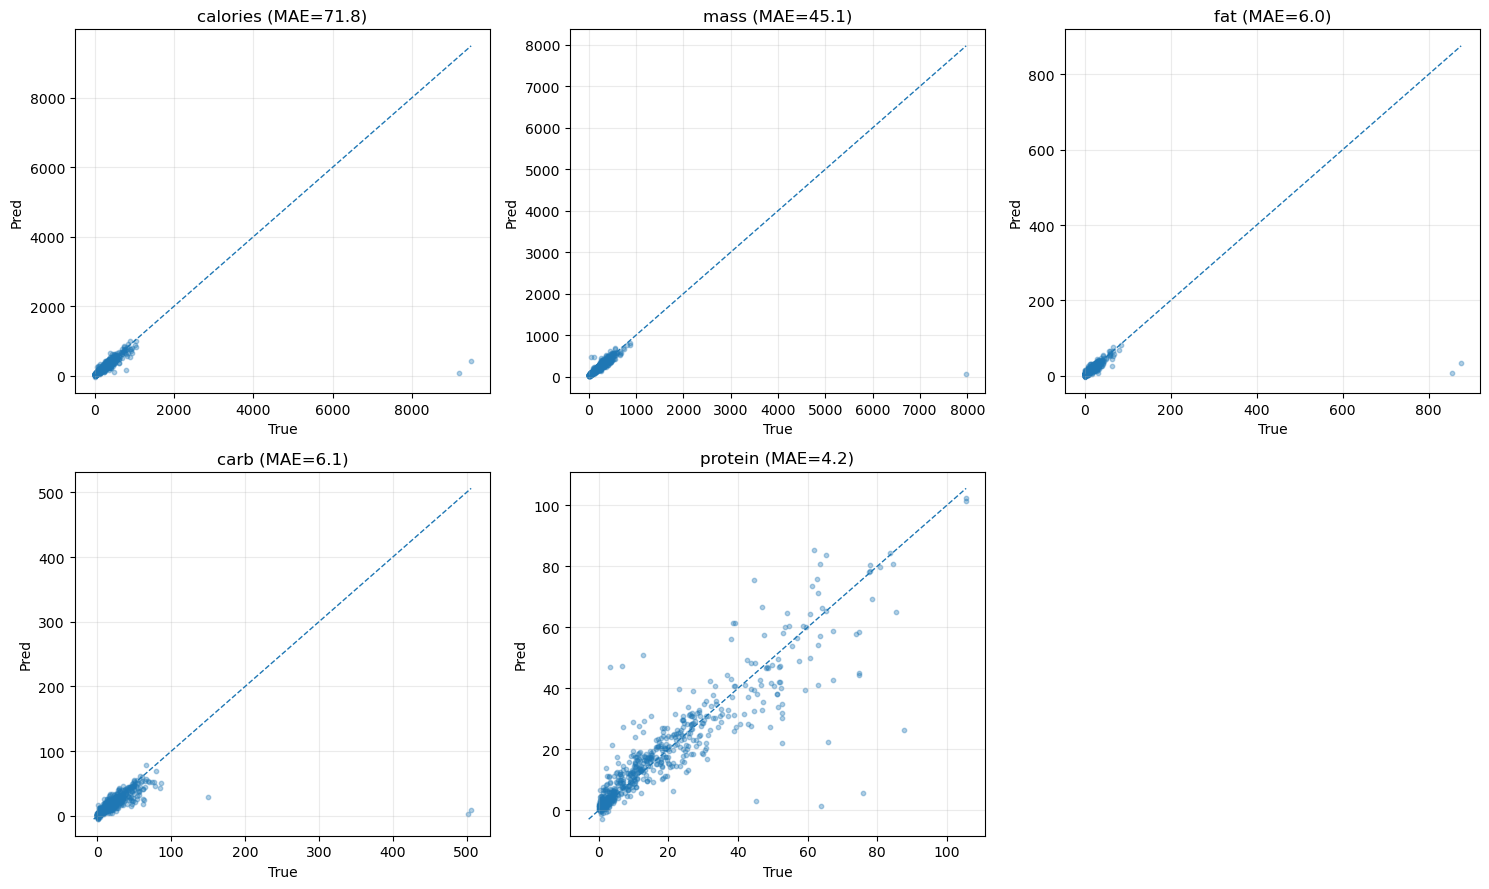

In [31]:
# ===== Report figures cell =====

from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

# --- 1) Curves: train/val loss + val MAE ---
epochs = history.get("epoch", list(range(1, len(history.get("train_loss_z", [])) + 1)))
train_loss = history.get("train_loss_z", [])
val_loss = history.get("val_loss_z", [])
val_mae_curve = history.get("val_mae", [])

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
if len(train_loss) > 0:
    plt.plot(epochs, train_loss, marker="o", label="train_loss_z (Huber)")
if len(val_loss) > 0:
    plt.plot(epochs, val_loss, marker="o", label="val_loss_z (Huber)")
plt.xlabel("Epoch")
plt.ylabel("Loss (z-space)")
plt.title("Training/Validation Loss (z-space)")
plt.grid(True, alpha=0.3)
plt.legend()

plt.subplot(1, 2, 2)
if len(val_mae_curve) > 0:
    plt.plot(epochs, val_mae_curve, marker="o", label="val_mae (mean over 5 targets)")
plt.xlabel("Epoch")
plt.ylabel("MAE (raw units)")
plt.title("Validation MAE (raw units)")
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

# --- 2) Compute test predictions to get per-target MAE + scatter plots ---
model_eval.eval()
t_mean = target_mean_eval.to(DEVICE)
t_std = target_std_eval.to(DEVICE)

y_true_all = []
y_pred_all = []

with torch.no_grad():
    for xb, yb, _ in test_dish_loader:
        xb = xb.to(DEVICE, non_blocking=True)   # (B,K,3,H,W)
        yb = yb.to(DEVICE, non_blocking=True)   # (B,5)

        # dish pooled forward in z-space using your existing helper
        pred_z = _dish_forward_z(model_eval, xb)  # (B,5)

        # de-standardize to raw units
        pred = pred_z * t_std + t_mean            # (B,5)

        y_true_all.append(yb.detach().cpu().numpy())
        y_pred_all.append(pred.detach().cpu().numpy())

y_true = np.concatenate(y_true_all, axis=0) if len(y_true_all) else np.zeros((0, len(TARGET_COLS)))
y_pred = np.concatenate(y_pred_all, axis=0) if len(y_pred_all) else np.zeros((0, len(TARGET_COLS)))

if y_true.shape[0] == 0:
    raise RuntimeError("No test samples found in `test_dish_loader`.")

abs_err = np.abs(y_pred - y_true)
mae_per_target = abs_err.mean(axis=0)
mae_mean = float(mae_per_target.mean())

rmse_per_target = np.sqrt(((y_pred - y_true) ** 2).mean(axis=0))

print("=== Test metrics (recomputed from predictions) ===")
print("Mean MAE (across 5 targets):", mae_mean)
for j, name in enumerate(TARGET_COLS):
    print(f"{name:>10s} | MAE={mae_per_target[j]:.3f} | RMSE={rmse_per_target[j]:.3f} | R2={r2_per_target[j]:.3f}")

# --- 3) Bar chart: test MAE per target ---
plt.figure(figsize=(10, 4))
x = np.arange(len(TARGET_COLS))
plt.bar(x, mae_per_target)
plt.xticks(x, TARGET_COLS, rotation=0)
plt.ylabel("MAE (raw units)")
plt.title("Test MAE per Target")
plt.grid(True, axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

# --- 4) Scatter: predicted vs true (per target) ---
cols = 3
rows = int(np.ceil(len(TARGET_COLS) / cols))
plt.figure(figsize=(5 * cols, 4.5 * rows))

for j, name in enumerate(TARGET_COLS, start=1):
    ax = plt.subplot(rows, cols, j)
    yt = y_true[:, j - 1]
    yp = y_pred[:, j - 1]

    ax.scatter(yt, yp, s=10, alpha=0.35)
    lo = float(min(np.min(yt), np.min(yp)))
    hi = float(max(np.max(yt), np.max(yp)))
    ax.plot([lo, hi], [lo, hi], linestyle="--", linewidth=1)

    ax.set_xlabel("True")
    ax.set_ylabel("Pred")
    ax.set_title(f"{name} (MAE={mae_per_target[j-1]:.1f})")
    ax.grid(True, alpha=0.25)

plt.tight_layout()
plt.show()

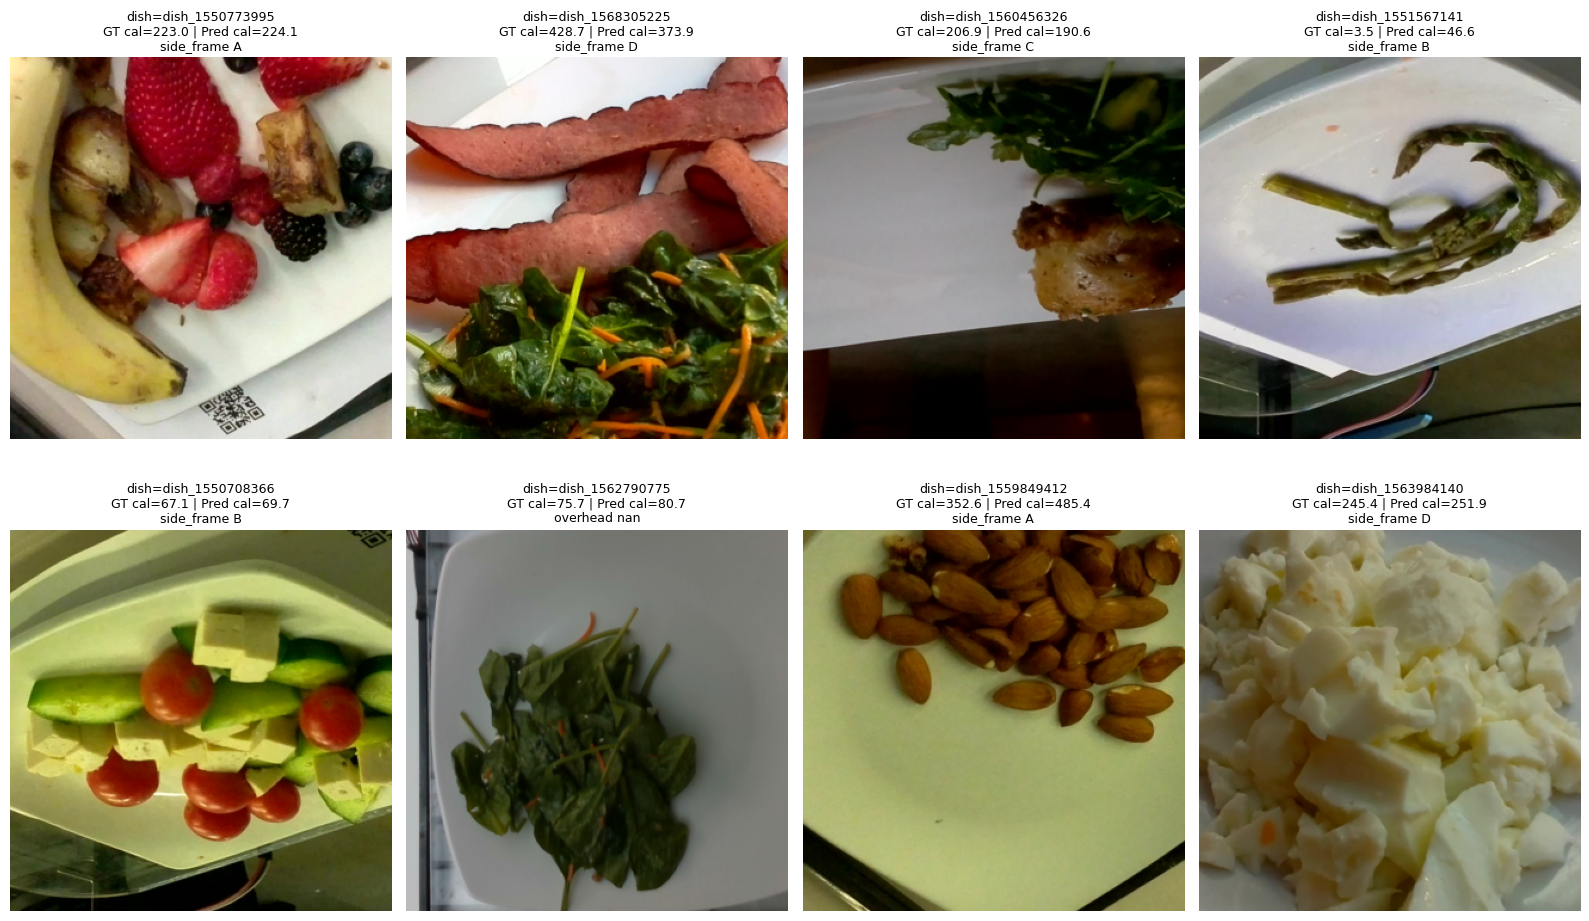

Per-sample details:
---
dish_id: dish_1550773995
path: prepared\test\dish_1550773995\images\frames_camera_A\camera_A_frame_000006.jpeg
GT  : calories=223.0, mass=285.0, fat=0.8, carb=55.6, protein=3.3
Pred: calories=224.1, mass=266.1, fat=4.7, carb=37.5, protein=8.6
---
dish_id: dish_1568305225
path: prepared\test\dish_1568305225\images\frames_camera_D\camera_D_frame_000002.jpeg
GT  : calories=428.7, mass=144.0, fat=35.1, carb=4.9, protein=24.5
Pred: calories=373.9, mass=108.3, fat=34.2, carb=-6.1, protein=21.3
---
dish_id: dish_1560456326
path: prepared\test\dish_1560456326\images\frames_camera_C\camera_C_frame_000004.jpeg
GT  : calories=206.9, mass=138.0, fat=7.5, carb=3.8, protein=29.7
Pred: calories=190.6, mass=135.1, fat=9.3, carb=4.5, protein=23.2
---
dish_id: dish_1551567141
path: prepared\test\dish_1551567141\images\frames_camera_B\camera_B_frame_000006.jpeg
GT  : calories=3.5, mass=17.0, fat=0.0, carb=0.7, protein=0.4
Pred: calories=46.6, mass=43.7, fat=2.3, carb=3.2, protein=

In [18]:
# Show random test samples with ground truth vs prediction
import math
import random
import numpy as np
import matplotlib.pyplot as plt

def denormalize_batch(t: torch.Tensor, mean=IMAGENET_MEAN, std=IMAGENET_STD):
    mean_t = torch.tensor(mean, dtype=t.dtype, device=t.device).view(1, 3, 1, 1)
    std_t = torch.tensor(std, dtype=t.dtype, device=t.device).view(1, 3, 1, 1)
    return t * std_t + mean_t

def format_targets(cols, y):
    # y: array-like length 5
    return ', '.join([f"{c}={float(v):.1f}" for c, v in zip(cols, y)])

N_SAMPLES = 8
random.seed(42)
idxs = random.sample(range(len(test_dataset)), k=min(N_SAMPLES, len(test_dataset)))

# Build a small batch manually
xb_list = []
yb_list = []
meta_list = []
for i in idxs:
    x, y, m = test_dataset[i]
    xb_list.append(x)
    yb_list.append(y)
    meta_list.append(m)

xb = torch.stack(xb_list, dim=0).to(DEVICE)
yb = torch.stack(yb_list, dim=0).to(DEVICE)

with torch.no_grad():
    with torch.amp.autocast(device_type=DEVICE.type, enabled=(DEVICE.type == 'cuda')):
        pred_z = model_eval(xb)
    pred = pred_z * target_std_eval.to(DEVICE) + target_mean_eval.to(DEVICE)

# Move to CPU for display
xb_cpu = denormalize_batch(xb.detach().cpu()).clamp(0, 1)
yb_cpu = yb.detach().cpu().numpy()
pred_cpu = pred.detach().cpu().numpy()

cols = list(target_cols_ckpt)
cal_idx = cols.index('calories') if 'calories' in cols else 0

cols_grid = 4
rows_grid = math.ceil(len(idxs) / cols_grid)
plt.figure(figsize=(4 * cols_grid, 5 * rows_grid))
for k, (img, y_true, y_pred, m) in enumerate(zip(xb_cpu, yb_cpu, pred_cpu, meta_list), start=1):
    ax = plt.subplot(rows_grid, cols_grid, k)
    ax.imshow(img.permute(1, 2, 0))
    dish = m.get('dish_id', '?')
    src = m.get('source', '')
    cam = m.get('camera', '')
    gt_cal = float(y_true[cal_idx])
    pr_cal = float(y_pred[cal_idx])
    ax.set_title(f"dish={dish}\nGT cal={gt_cal:.1f} | Pred cal={pr_cal:.1f}\n{src} {cam}", fontsize=9)
    ax.axis('off')
plt.tight_layout()
plt.show()

print('Per-sample details:')
for m, y_true, y_pred in zip(meta_list, yb_cpu, pred_cpu):
    dish = m.get('dish_id', '?')
    path = m.get('path', '')
    print('---')
    print('dish_id:', dish)
    print('path:', path)
    print('GT  :', format_targets(cols, y_true))
    print('Pred:', format_targets(cols, y_pred))

# 4. XAI Explaination

In [19]:
# XAI helpers (load model if needed, prediction helpers, normalization)
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from torchvision.models import convnext_tiny, ConvNeXt_Tiny_Weights


def _normalize_imagenet(x01: torch.Tensor, mean=IMAGENET_MEAN, std=IMAGENET_STD) -> torch.Tensor:
    # x01: (B,3,H,W) in [0,1]
    mean_t = torch.tensor(mean, dtype=x01.dtype, device=x01.device).view(1, 3, 1, 1)
    std_t = torch.tensor(std, dtype=x01.dtype, device=x01.device).view(1, 3, 1, 1)
    return (x01 - mean_t) / std_t


def _denormalize_imagenet(x: torch.Tensor, mean=IMAGENET_MEAN, std=IMAGENET_STD) -> torch.Tensor:
    # x: (B,3,H,W) normalized
    mean_t = torch.tensor(mean, dtype=x.dtype, device=x.device).view(1, 3, 1, 1)
    std_t = torch.tensor(std, dtype=x.dtype, device=x.device).view(1, 3, 1, 1)
    return x * std_t + mean_t


def _ensure_eval_model_loaded():
    # Uses the checkpoint produced earlier.
    global model_eval, target_mean_eval, target_std_eval, target_cols_ckpt, ckpt
    if 'model_eval' in globals() and model_eval is not None:
        return

    ckpt_path = Path('convnext_tiny_nutrition5k_bestperdish.pt')
    assert ckpt_path.exists(), f'Missing checkpoint: {ckpt_path.resolve()}'
    ckpt = torch.load(ckpt_path, map_location='cpu')

    weights = ConvNeXt_Tiny_Weights.DEFAULT
    m = convnext_tiny(weights=weights)
    target_cols_ckpt = ckpt.get('target_cols', TARGET_COLS)
    m.classifier[-1] = torch.nn.Linear(m.classifier[-1].in_features, len(target_cols_ckpt))
    m.load_state_dict(ckpt['model_state_dict'], strict=True)

    model_eval = m.to(DEVICE).eval()
    target_mean_eval = ckpt.get('target_mean', target_mean)
    target_std_eval = ckpt.get('target_std', target_std)
    print('Loaded model for XAI:', ckpt_path.resolve())


def predict_raw(model, x_norm: torch.Tensor, target_mean_t: torch.Tensor, target_std_t: torch.Tensor) -> torch.Tensor:
    # Returns raw-unit predictions (B,5) given ImageNet-normalized input
    with torch.no_grad():
        with torch.amp.autocast(device_type=DEVICE.type, enabled=(DEVICE.type == 'cuda')):
            pred_z = model(x_norm)
        pred = pred_z * target_std_t.to(DEVICE) + target_mean_t.to(DEVICE)
    return pred


_ensure_eval_model_loaded()
cols = list(target_cols_ckpt)
cal_idx = cols.index('calories') if 'calories' in cols else 0
mean_cal = float(target_mean_eval[cal_idx])
print('Calories index:', cal_idx, '| Dataset mean calories (train mean):', mean_cal)


Calories index: 0 | Dataset mean calories (train mean): 200.8631134033203


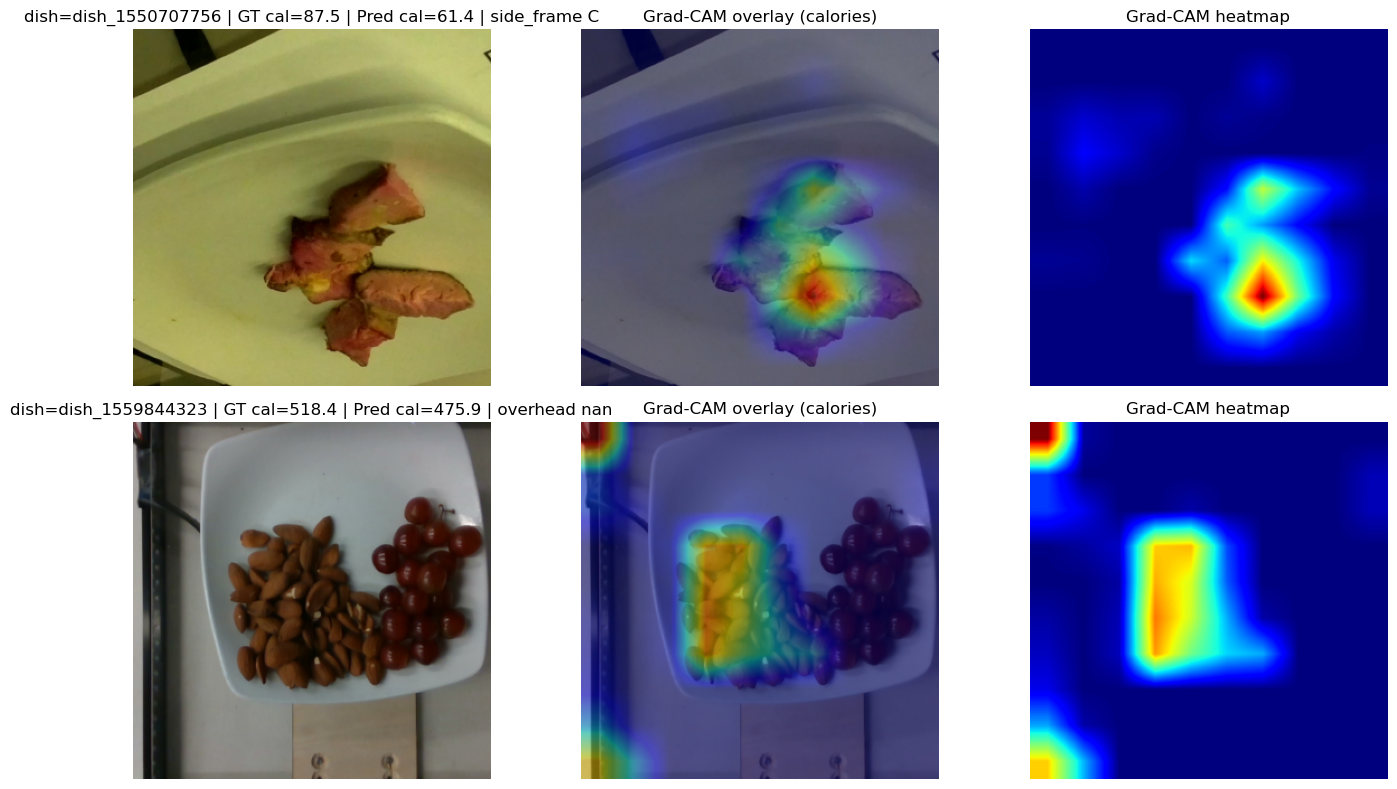

In [41]:
# Grad-CAM (feature importance)
import matplotlib.cm as cm

class GradCAM:
    def __init__(self, model: torch.nn.Module, target_layer: torch.nn.Module):
        self.model = model
        self.target_layer = target_layer
        self.activations = None
        self.gradients = None
        self._hook = None
        self._register_hook()

    def _register_hook(self):
        def fwd_hook(module, inp, out):
            self.activations = out
            if isinstance(out, torch.Tensor) and out.requires_grad:
                out.register_hook(self._save_grad)
        self._hook = self.target_layer.register_forward_hook(fwd_hook)

    def _save_grad(self, grad):
        self.gradients = grad

    def remove(self):
        if self._hook is not None:
            self._hook.remove()
            self._hook = None

    def __call__(self, x_norm: torch.Tensor, target_index: int) -> torch.Tensor:
        self.model.zero_grad(set_to_none=True)
        self.gradients = None
        self.activations = None

        with torch.amp.autocast(device_type=DEVICE.type, enabled=(DEVICE.type == 'cuda')):
            out_z = self.model(x_norm)  # (B,5) in z-space
            score = out_z[:, target_index].sum()
        score.backward()

        if self.activations is None or self.gradients is None:
            raise RuntimeError('Grad-CAM did not capture activations/gradients.')

        grads = self.gradients
        acts = self.activations
        if grads.ndim != 4 or acts.ndim != 4:
            raise RuntimeError(f'Expected 4D activations/grads, got acts={acts.shape}, grads={grads.shape}')

        weights = grads.mean(dim=(2, 3), keepdim=True)  # (B,C,1,1)
        cam_map = (weights * acts).sum(dim=1, keepdim=True)  # (B,1,H,W)
        cam_map = F.relu(cam_map)

        # Normalize each sample to [0,1]
        b, _, h, w = cam_map.shape
        cam_map = cam_map.view(b, -1)
        cam_min = cam_map.min(dim=1, keepdim=True).values
        cam_max = cam_map.max(dim=1, keepdim=True).values
        cam_map = (cam_map - cam_min) / (cam_max - cam_min + 1e-8)
        cam_map = cam_map.view(b, 1, h, w)
        return cam_map
    
# ConvNeXt-Tiny: hook into the `features` module (convolutional backbone)
cam_explainer = GradCAM(model_eval, target_layer=model_eval.features)

N = 2
idxs = np.random.choice(len(test_dataset), size=min(N, len(test_dataset)), replace=False).tolist()

imgs = []
titles = []
for idx in idxs:
    x_norm, y, m = test_dataset[idx]  # already ImageNet-normalized
    xb = x_norm.unsqueeze(0).to(DEVICE).requires_grad_(True)

    cam_map = cam_explainer(xb, target_index=cal_idx)
    cam_up = F.interpolate(cam_map, size=xb.shape[-2:], mode='bilinear', align_corners=False)
    cam_up = cam_up[0, 0].detach().cpu().numpy()

    pred = predict_raw(model_eval, xb, target_mean_eval, target_std_eval)[0].detach().cpu().numpy()
    gt = y.detach().cpu().numpy()
    gt_cal = float(gt[cal_idx])
    pr_cal = float(pred[cal_idx])

    x01 = _denormalize_imagenet(xb.detach().cpu())[0].clamp(0, 1)
    img = x01.permute(1, 2, 0).numpy()

    heat = cm.jet(cam_up)[..., :3]
    overlay = (0.55 * img + 0.45 * heat).clip(0, 1)

    imgs.append((img, overlay, cam_up))
    dish = m.get('dish_id', '?')
    src = m.get('source', '')
    cam = m.get('camera', '')
    titles.append(f"dish={dish} | GT cal={gt_cal:.1f} | Pred cal={pr_cal:.1f} | {src} {cam}")

rows = len(imgs)
plt.figure(figsize=(14, 4 * rows))
for i, ((img, overlay, cam_up), title) in enumerate(zip(imgs, titles), start=1):
    ax1 = plt.subplot(rows, 3, (i - 1) * 3 + 1)
    ax1.imshow(img)
    ax1.set_title(title)
    ax1.axis('off')

    ax2 = plt.subplot(rows, 3, (i - 1) * 3 + 2)
    ax2.imshow(overlay)
    ax2.set_title('Grad-CAM overlay (calories)')
    ax2.axis('off')

    ax3 = plt.subplot(rows, 3, (i - 1) * 3 + 3)
    ax3.imshow(cam_up, cmap='jet')
    ax3.set_title('Grad-CAM heatmap')
    ax3.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Grad-CAM robustness validation
import numpy as np
import torch
import torch.nn.functional as F
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from typing import Tuple

def compute_cam_for_image(x_norm: torch.Tensor, target_index: int) -> np.ndarray:
    """Compute upsampled CAM for a single normalized image tensor (3,H,W)."""
    xb = x_norm.unsqueeze(0).to(DEVICE).requires_grad_(True)
    cam_map = cam_explainer(xb, target_index=target_index)  # (1,1,hc,wc)
    cam_up = F.interpolate(cam_map, size=xb.shape[-2:], mode='bilinear', align_corners=False)
    cam_np = cam_up[0, 0].detach().cpu().numpy()
    # robust norm to [0,1]
    lo = np.percentile(cam_np, 5.0)
    hi = np.percentile(cam_np, 99.5)
    cam_np = np.clip((cam_np - lo) / (hi - lo + 1e-8), 0.0, 1.0)
    return cam_np

def mask_topk_from_cam(cam: np.ndarray, top_k_pct: float) -> np.ndarray:
    """Return boolean mask where True are the top_k_pct most important pixels."""
    if top_k_pct <= 0 or top_k_pct >= 100:
        raise ValueError("top_k_pct must be in (0,100)")
    thr = np.percentile(cam.flatten(), 100.0 - top_k_pct)
    return (cam >= thr)

def apply_mask_to_norm_image(x_norm: torch.Tensor, mask: np.ndarray, fill: float = 0.0) -> torch.Tensor:
    """Apply boolean mask (H,W) to normalized image (3,H,W) by zeroing masked pixels in pixel space, then re-normalize."""
    x01 = _denormalize_imagenet(x_norm.unsqueeze(0)).clamp(0, 1)[0]  # (3,H,W)
    mask_t = torch.tensor(mask, dtype=x01.dtype, device=x01.device).unsqueeze(0)  # (1,H,W)
    # zero-out masked pixels (remove important region)
    x01_masked = x01 * (1.0 - mask_t) + fill * mask_t
    x_norm_masked = _normalize_imagenet(x01_masked.unsqueeze(0))[0]
    return x_norm_masked

def pearsonr(a: np.ndarray, b: np.ndarray) -> float:
    a = a.flatten()
    b = b.flatten()
    if a.std() == 0 or b.std() == 0:
        return float('nan')
    return float(np.corrcoef(a, b)[0, 1])

def spearmanr_approx(a: np.ndarray, b: np.ndarray) -> float:
    # simple rank-based Spearman (works without scipy)
    ra = np.argsort(np.argsort(a.flatten().astype(np.float64)))
    rb = np.argsort(np.argsort(b.flatten().astype(np.float64)))
    if ra.std() == 0 or rb.std() == 0:
        return float('nan')
    return float(np.corrcoef(ra, rb)[0, 1])

def small_perturbation(x_norm: torch.Tensor, seed: int = 0) -> torch.Tensor:
    """Apply a small random perturbation to x_norm (brightness jitter + small random crop/rescale)."""
    torch.manual_seed(seed)
    x01 = _denormalize_imagenet(x_norm.unsqueeze(0))[0]  # (3,H,W)
    c, h, w = x01.shape
    # brightness jitter
    bright = float(1.0 + (np.random.randn() * 0.05))  # +/-5%
    x01_b = (x01 * bright).clamp(0, 1)
    # small random crop + resize back
    scale = float(0.94 + 0.06 * np.random.rand())  # 0.94-1.0
    new_h = max(2, int(h * scale))
    new_w = max(2, int(w * scale))
    top = np.random.randint(0, h - new_h + 1) if h != new_h else 0
    left = np.random.randint(0, w - new_w + 1) if w != new_w else 0
    crop = x01_b[:, top:top+new_h, left:left+new_w].unsqueeze(0)  # (1,3,nh,nw)
    crop_rs = F.interpolate(crop, size=(h, w), mode='bilinear', align_corners=False)[0]
    # small additive Gaussian noise
    noise = torch.randn_like(crop_rs) * 0.01
    x01_p = (crop_rs + noise).clamp(0, 1)
    return _normalize_imagenet(x01_p.unsqueeze(0))[0]

# Parameters
N_SAMPLES = min(100, len(test_dataset))   # number of images to test
N_PERTURBS = 3                            # per-image perturbations to measure stability
TOP_K_LIST = [5.0, 10.0, 20.0]            # percentages for mask-based causal test

# Logging accumulators
stability_pearsons = []
stability_spearmans = []
causal_results = {k: [] for k in TOP_K_LIST}

# Main loop (random sample of images)
rng = np.random.default_rng(42)
sample_idxs = rng.choice(len(test_dataset), size=N_SAMPLES, replace=False).tolist()

for i, idx in enumerate(sample_idxs, start=1):
    x_norm, y_true, meta = test_dataset[idx]
    # compute baseline CAM and prediction
    cam_base = compute_cam_for_image(x_norm, target_index=cal_idx)
    pred_base = predict_raw(model_eval, x_norm.unsqueeze(0).to(DEVICE), target_mean_eval, target_std_eval)[0].cpu().numpy()
    cal_base = float(pred_base[cal_idx])

    # Stability under small perturbations
    pearson_list = []
    spearman_list = []
    for p in range(N_PERTURBS):
        xp = small_perturbation(x_norm, seed=(i * 100 + p))
        cam_p = compute_cam_for_image(xp, target_index=cal_idx)
        pearson_list.append(pearsonr(cam_base, cam_p))
        spearman_list.append(spearmanr_approx(cam_base, cam_p))
    stability_pearsons.append(np.nanmean(pearson_list))
    stability_spearmans.append(np.nanmean(spearman_list))

    # Causal perturbation: mask top-k% and measure Δpred
    for top_k in TOP_K_LIST:
        mask = mask_topk_from_cam(cam_base, top_k_pct=top_k)
        x_masked = apply_mask_to_norm_image(x_norm, mask)
        pred_masked = predict_raw(model_eval, x_masked.unsqueeze(0).to(DEVICE), target_mean_eval, target_std_eval)[0].cpu().numpy()
        cal_masked = float(pred_masked[cal_idx])
        delta = cal_masked - cal_base
        causal_results[top_k].append(delta)

# Summary reporting
print("Grad-CAM robustness summary:")
print(f"Samples tested: {N_SAMPLES} | Perturbations per sample: {N_PERTURBS}")
print(f"Stability (Pearson) mean: {np.nanmean(stability_pearsons):.3f} | std: {np.nanstd(stability_pearsons):.3f}")
print(f"Stability (Spearman) mean: {np.nanmean(stability_spearmans):.3f} | std: {np.nanstd(stability_spearmans):.3f}")
print("")
print("Causal masking results (mean Δpred on calories after masking top-k% CAM pixels):")
for top_k in TOP_K_LIST:
    arr = np.array(causal_results[top_k])
    print(f" Top-{int(top_k)}%: mean Δpred = {arr.mean():+.2f} kcal | std = {arr.std():.2f} | median = {np.median(arr):+.2f}")

# Inspect top/bottom examples by absolute Δpred
TOP_K = 10.0
N_SHOW = 2

deltas = np.array(causal_results.get(TOP_K, []))  # order matches sample_idxs
if len(deltas) == 0:
    print('No causal results found for Top-K masking; run the robustness cell first.')
else:
    abs_vals = np.abs(deltas)
    order_desc = np.argsort(-abs_vals)  # indices into sample_idxs (descending absolute impact)

    for rank in range(min(N_SHOW, len(order_desc))):
        s_pos = order_desc[rank]
        dataset_idx = sample_idxs[s_pos]
        x_norm, y_true, meta = test_dataset[dataset_idx]
        cam = compute_cam_for_image(x_norm, target_index=cal_idx)
        mask = mask_topk_from_cam(cam, top_k_pct=TOP_K)
        x_masked = apply_mask_to_norm_image(x_norm, mask)

        pred_base = predict_raw(model_eval, x_norm.unsqueeze(0).to(DEVICE), target_mean_eval, target_std_eval)[0].cpu().numpy()
        pred_masked = predict_raw(model_eval, x_masked.unsqueeze(0).to(DEVICE), target_mean_eval, target_std_eval)[0].cpu().numpy()
        delta_val = float(pred_masked[cal_idx] - pred_base[cal_idx])

        img = _denormalize_imagenet(x_norm.unsqueeze(0)).clamp(0,1)[0].permute(1,2,0).numpy()
        heat = cm.jet(cam)[..., :3]
        overlay = (0.55 * img + 0.45 * heat).clip(0,1)
        img_masked = _denormalize_imagenet(x_masked.unsqueeze(0)).clamp(0,1)[0].permute(1,2,0).numpy()

        plt.figure(figsize=(12,4))
        plt.suptitle(f"Dataset idx={dataset_idx} | Δpred (Top-{int(TOP_K)}%) = {delta_val:+.2f} kcal")
        plt.subplot(1,3,1); plt.imshow(img); plt.title('Original'); plt.axis('off')
        plt.subplot(1,3,2); plt.imshow(overlay); plt.title('Grad-CAM overlay'); plt.axis('off')
        plt.subplot(1,3,3); plt.imshow(img_masked); plt.title('Masked image'); plt.axis('off')
        plt.show()

In [61]:
SEED = 40
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

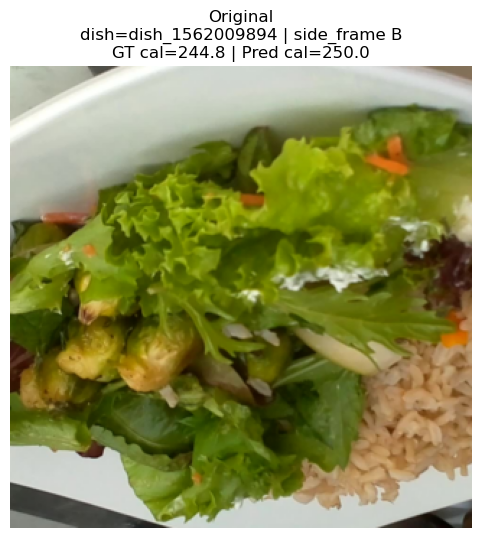

Default target is dataset mean calories: 200.9
Running counterfactual: Pred cal 250.0 -> target 100.0
step 001/200 | pred_cal=250.03 | target=100.00 | loss=22508.1914
step 050/200 | pred_cal=94.33 | target=100.00 | loss=32.1459
step 100/200 | pred_cal=103.23 | target=100.00 | loss=10.4663
step 150/200 | pred_cal=97.14 | target=100.00 | loss=8.2114
step 200/200 | pred_cal=96.79 | target=100.00 | loss=10.2969
Pred calories: before=250.0 -> after=99.7 (target=100.0)


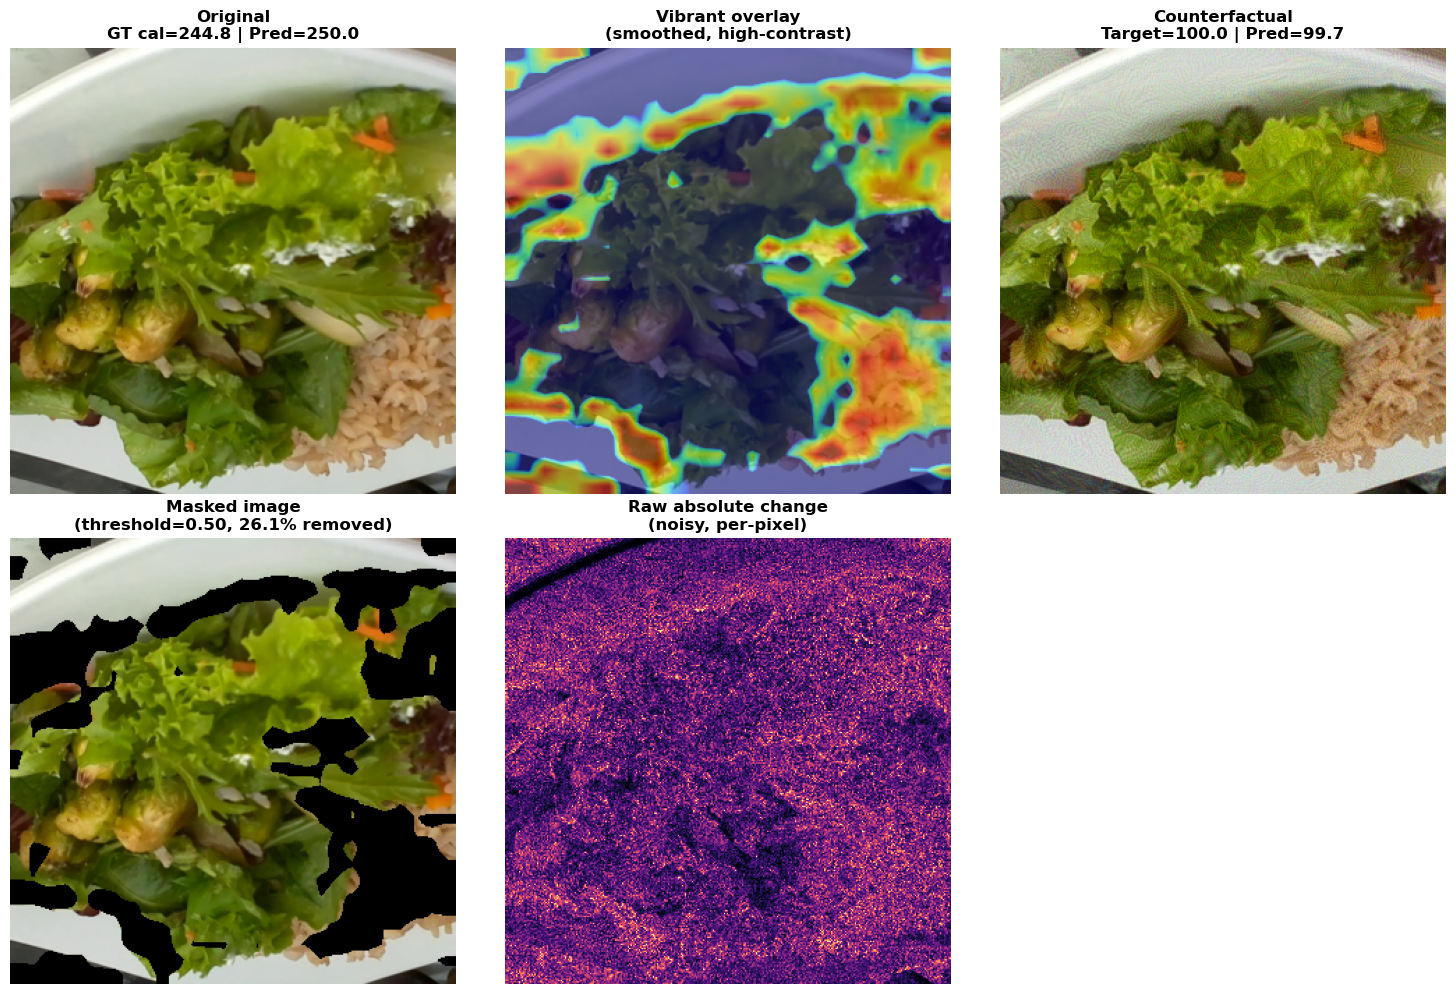

In [62]:
# Counterfactual (CEM-style): minimally edit the image to move calories prediction toward a user-specified target
#
# This is a pixel-space, model-specific counterfactual. The absolute-change map can look like "noise" because
# the optimizer exploits model sensitivity to small texture changes.
#
# We visualize a Grad-CAM-like "region" heatmap by:
# - turning the per-pixel absolute delta into a grayscale map
# - downsampling -> upsampling (coarser, contiguous regions)
# - robust percentile normalization (clearer contrast)

def total_variation(x01: torch.Tensor) -> torch.Tensor:
    # x01: (1,3,H,W) in [0,1]
    tv_h = torch.mean(torch.abs(x01[:, :, 1:, :] - x01[:, :, :-1, :]))
    tv_w = torch.mean(torch.abs(x01[:, :, :, 1:] - x01[:, :, :, :-1]))
    return tv_h + tv_w


def _safe_logit(x: torch.Tensor, eps: float = 1e-4) -> torch.Tensor:
    x = x.clamp(eps, 1.0 - eps)
    return torch.log(x) - torch.log1p(-x)


def _overlay_heatmap(img01: np.ndarray, heat01: np.ndarray, cmap_name: str = 'jet', alpha: float = 0.65) -> np.ndarray:
    """Overlay a [0,1] heatmap over an RGB image in [0,1]."""
    import matplotlib

    heat01 = np.clip(heat01, 0.0, 1.0)
    cmap = matplotlib.colormaps.get_cmap(cmap_name)  # avoids deprecated get_cmap
    heat_rgb = cmap(heat01)[..., :3]  # (H,W,3)
    out = (1.0 - alpha) * img01 + alpha * heat_rgb
    return np.clip(out, 0.0, 1.0)


def _gradcam_like_from_delta(
    delta_gray: np.ndarray,
    down_size: int = 28,
    q_low: float = 60.0,
    q_high: float = 99.7,
    gamma: float = 0.45,
) -> np.ndarray:
    """Turn a noisy pixel delta map into a smoother, Grad-CAM-like region map in [0,1]."""
    h, w = delta_gray.shape

    # Downsample/upsample to encourage contiguous regions (like Grad-CAM resolution)
    heat_t = torch.tensor(delta_gray, dtype=torch.float32).view(1, 1, h, w)
    heat_t = F.interpolate(heat_t, size=(down_size, down_size), mode='area')
    heat_t = F.interpolate(heat_t, size=(h, w), mode='bilinear', align_corners=False)
    heat = heat_t[0, 0].cpu().numpy()

    # Robust normalization using percentiles (improves contrast vs max-normalizing)
    lo = float(np.percentile(heat, q_low))
    hi = float(np.percentile(heat, q_high))
    heat = (heat - lo) / (hi - lo + 1e-8)
    heat = np.clip(heat, 0.0, 1.0)

    # Gamma < 1 boosts mid-range values (more visible regions)
    heat = np.power(heat, gamma)
    return heat


def _normalize_map_noisy(delta_gray: np.ndarray, q_high: float = 99.5) -> np.ndarray:
    """Normalize a raw/noisy delta map into [0,1] for display (no smoothing)."""
    denom = float(np.percentile(delta_gray, q_high))
    denom = max(denom, 1e-8)
    out = delta_gray / denom
    return np.clip(out, 0.0, 1.0)


def counterfactual_toward_target_calories(
    x_norm: torch.Tensor,
    target_cal: float,
    steps: int = 200,
    lr: float = 0.02,
    lam_l2: float = 10.0,
    lam_tv: float = 0.05,
    grad_clip: float = 1.0,
    print_every: int = 50,
):
    """Optimize a bounded image (via sigmoid parameterization) to move predicted calories toward target_cal.

    Stability choices:
    - No AMP/autocast inside optimization loop
    - Optimize unconstrained parameter u, map to image via sigmoid(u) in [0,1]
    - Finite-loss guard + gradient clipping
    """

    # x_norm: (3,H,W) normalized
    x_norm = x_norm.unsqueeze(0).to(DEVICE)

    # Start point in pixel space
    x01_0 = _denormalize_imagenet(x_norm).clamp(0, 1).detach().float()  # (1,3,H,W) in [0,1]

    # Unconstrained parameterization for stability: x01 = sigmoid(u)
    u = _safe_logit(x01_0).detach().requires_grad_(True)
    opt = torch.optim.Adam([u], lr=lr)

    tgt = torch.tensor([float(target_cal)], device=DEVICE, dtype=torch.float32)

    last_good_u = u.detach().clone()

    for t in range(1, steps + 1):
        opt.zero_grad(set_to_none=True)

        x01 = torch.sigmoid(u)
        x_norm_cur = _normalize_imagenet(x01)

        # IMPORTANT: keep this in fp32 to avoid fp16 NaNs during optimization
        pred_z = model_eval(x_norm_cur.float())

        pred = pred_z * target_std_eval.to(DEVICE) + target_mean_eval.to(DEVICE)
        pred_cal = pred[:, cal_idx]  # (1,)

        loss_target = (pred_cal - tgt).pow(2).mean()
        loss_l2 = (x01 - x01_0).pow(2).mean()
        loss_tv = total_variation(x01)
        loss = loss_target + lam_l2 * loss_l2 + lam_tv * loss_tv

        if not torch.isfinite(loss):
            print(
                f"step {t:03d}/{steps} | loss became non-finite; "
                f"pred_cal={float(pred_cal.detach().cpu().item()):.3f}"
            )
            # revert to last good parameters
            u = last_good_u.detach().clone().requires_grad_(True)
            break

        loss.backward()

        if grad_clip is not None and grad_clip > 0:
            torch.nn.utils.clip_grad_norm_([u], max_norm=grad_clip)

        opt.step()
        last_good_u = u.detach().clone()

        if (t % print_every) == 0 or t == 1 or t == steps:
            print(
                f"step {t:03d}/{steps} | pred_cal={float(pred_cal.item()):.2f} | "
                f"target={float(target_cal):.2f} | loss={float(loss.item()):.4f}"
            )

    x01_final = torch.sigmoid(u.detach()).clamp(0, 1)
    x_norm_final = _normalize_imagenet(x01_final)

    with torch.no_grad():
        pred0 = predict_raw(model_eval, _normalize_imagenet(x01_0), target_mean_eval, target_std_eval)[0]
        pred1 = predict_raw(model_eval, x_norm_final, target_mean_eval, target_std_eval)[0]

    return x01_0.cpu()[0], x01_final.cpu()[0], pred0.cpu().numpy(), pred1.cpu().numpy()


# --- Interactive demo ---
idx = int(np.random.randint(0, len(test_dataset)))
x_norm, y_true, m = test_dataset[idx]

dish = m.get('dish_id', '?')
src = m.get('source', '')
cam = m.get('camera', '')
gt_cal = float(y_true[cal_idx])

# Show original image + GT/pred first
with torch.no_grad():
    x01_0 = _denormalize_imagenet(x_norm.unsqueeze(0).to(DEVICE)).clamp(0, 1)
    pred_before = predict_raw(model_eval, _normalize_imagenet(x01_0), target_mean_eval, target_std_eval)[0].detach().cpu().numpy()

pr_before = float(pred_before[cal_idx])
img0 = x01_0.detach().cpu()[0].permute(1, 2, 0).numpy()

plt.figure(figsize=(6, 6))
plt.imshow(img0)
plt.title(f"Original\ndish={dish} | {src} {cam}\nGT cal={gt_cal:.1f} | Pred cal={pr_before:.1f}")
plt.axis('off')
plt.show()

# Ask user for a target calories value
print(f"Default target is dataset mean calories: {mean_cal:.1f}")
user_in = input("Enter target calories (press Enter for default): ").strip()
if user_in == "":
    target_cal = float(mean_cal)
else:
    try:
        target_cal = float(user_in)
    except ValueError:
        print("Could not parse input; using default mean calories.")
        target_cal = float(mean_cal)

print(f"Running counterfactual: Pred cal {pr_before:.1f} -> target {target_cal:.1f}")

x0, xcf, pred0, predcf = counterfactual_toward_target_calories(
    x_norm=x_norm,
    target_cal=target_cal,
    steps=200,
    lr=0.02,
    lam_l2=10.0,
    lam_tv=0.05,
    grad_clip=1.0,
    print_every=50,
)

pr0 = float(pred0[cal_idx])
pr1 = float(predcf[cal_idx])
print(f"Pred calories: before={pr0:.1f} -> after={pr1:.1f} (target={target_cal:.1f})")

# Visualize original vs counterfactual and overlay a vibrant, Grad-CAM-like heatmap
img1 = xcf.permute(1, 2, 0).numpy()
delta = np.abs(img1 - img0)
delta_gray = delta.mean(axis=2)

# Vibrant overlay uses smoothed, high-contrast map
heat_overlay = _gradcam_like_from_delta(delta_gray, down_size=28, q_low=60.0, q_high=99.7, gamma=0.45)
overlay = _overlay_heatmap(img0, heat_overlay, cmap_name='jet', alpha=0.5)

# Raw/noisy map (often clearer for understanding pixel-level changes)
heat_noisy = _normalize_map_noisy(delta_gray, q_high=99.5)

# Visualize in 2 rows (row 1: original, overlay, counterfactual; row 2: masked, raw heatmap)
plt.figure(figsize=(15, 10))

ax1 = plt.subplot(2, 3, 1)
ax1.imshow(img0)
ax1.set_title(f"Original\nGT cal={gt_cal:.1f} | Pred={pr0:.1f}", fontsize=12, fontweight='bold')
ax1.axis('off')

ax2 = plt.subplot(2, 3, 2)
ax2.imshow(overlay)
ax2.set_title('Vibrant overlay\n(smoothed, high-contrast)', fontsize=12, fontweight='bold')
ax2.axis('off')

ax3 = plt.subplot(2, 3, 3)
ax3.imshow(img1)
ax3.set_title(f"Counterfactual\nTarget={target_cal:.1f} | Pred={pr1:.1f}", fontsize=12, fontweight='bold')
ax3.axis('off')

# Row 2: masked and raw heatmap
threshold_val = 0.5
mask = heat_overlay > threshold_val
img_masked = img0.copy()
img_masked[mask] = 0

ax4 = plt.subplot(2, 3, 4)
ax4.imshow(img_masked)
ax4.set_title(f'Masked image\n(threshold={threshold_val:.2f}, {100*mask.mean():.1f}% removed)', 
              fontsize=12, fontweight='bold')
ax4.axis('off')

ax5 = plt.subplot(2, 3, 5)
ax5.imshow(heat_noisy, cmap='magma')
ax5.set_title('Raw absolute change\n(noisy, per-pixel)', fontsize=12, fontweight='bold')
ax5.axis('off')

plt.tight_layout()
plt.show()
